# COMP 551 - Assignment 4

**Group Number:** 10<br><br>
**Members:**
  * **Ayaz Ciplak** - 261013785<br>
  * **Jackie Silver** - 261012002<br>
  * **Christopher Smith** - 261013926<br><br>

***Notes:***
  * *Rename/save this file as code.ipynb before submitting*

## **Task 1: Preprocess the dataset**

### **Environment Configuration**

Package Installations

In [1]:
!pip install emoji
!pip install datasets
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.5 MB/s eta 0:00:00

Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re # Regex
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, AutoConfig

import emoji
import time
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn as nn
from bertviz import head_view
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

**Load Dataset Splits**

In [3]:
splits = {
    'train': 'simplified/train-00000-of-00001.parquet',
    'validation': 'simplified/validation-00000-of-00001.parquet',
    'test': 'simplified/test-00000-of-00001.parquet'
    }


train_df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/" + splits["train"])
validation_df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/" + splits["validation"])
test_df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(train_df)
#print(validation_df)
#print(test_df)

                                                    text labels       id
0      My favourite food is anything I didn't have to...   [27]  eebbqej
1      Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                         WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                            To make her feel threatened   [14]  ed7ypvh
4                                 Dirty Southern Wankers    [3]  ed0bdzj
...                                                  ...    ...      ...
43405  Added you mate well I’ve just got the bow and ...   [18]  edsb738
43406  Always thought that was funny but is it a refe...    [6]  ee7fdou
43407  What are you talking about? Anything bad that ...    [3]  efgbhks
43408            More like a baptism, with sexy results!   [13]  ed1naf8
43409                                    Enjoy the ride!   [17]  eecwmbq

[43410 rows x 3 columns]


### **General Preprocessing**

Here, we preprocess the data by dropping the comment rows which don't have exactly one label, and turning this one label into a numerical value rather than a list. We also drop any rows that appear more than once.

In [5]:
#filter each df split so each comment has 1 numerical label

#only keep comments with 1 label
one_label_train_df = train_df[train_df['labels'].apply(lambda x : len(x) == 1)]
#print(one_label_train_df)

#then take the label out of the list
clean_train_df = one_label_train_df.copy() #below only seems to work with a copy
clean_train_df['labels'] = one_label_train_df['labels'].apply(lambda x : x[0])
print(clean_train_df)

one_label_validation_df = validation_df[validation_df['labels'].apply(lambda x : len(x) == 1)]
#print(one_label_train_df)

clean_validation_df = one_label_validation_df.copy()
clean_validation_df['labels'] = one_label_validation_df['labels'].apply(lambda x : x[0])
#print(clean_validation_df)

one_label_test_df = test_df[test_df['labels'].apply(lambda x : len(x) == 1)]
#print(one_label_train_df)

clean_test_df = one_label_test_df.copy()
clean_test_df['labels'] = one_label_test_df['labels'].apply(lambda x : x[0])
#print(clean_test_df)

                                                    text  labels       id
0      My favourite food is anything I didn't have to...      27  eebbqej
1      Now if he does off himself, everyone will thin...      27  ed00q6i
2                         WHY THE FUCK IS BAYLESS ISOING       2  eezlygj
3                            To make her feel threatened      14  ed7ypvh
4                                 Dirty Southern Wankers       3  ed0bdzj
...                                                  ...     ...      ...
43405  Added you mate well I’ve just got the bow and ...      18  edsb738
43406  Always thought that was funny but is it a refe...       6  ee7fdou
43407  What are you talking about? Anything bad that ...       3  efgbhks
43408            More like a baptism, with sexy results!      13  ed1naf8
43409                                    Enjoy the ride!      17  eecwmbq

[36308 rows x 3 columns]


In [6]:
# Drop any duplicate rows, if present
clean_train_df = clean_train_df.drop_duplicates()
clean_validation_df = clean_validation_df.drop_duplicates()
clean_test_df = clean_test_df.drop_duplicates()

print(clean_train_df)
#print(clean_validation_df)
#print(clean_test_df)

                                                    text  labels       id
0      My favourite food is anything I didn't have to...      27  eebbqej
1      Now if he does off himself, everyone will thin...      27  ed00q6i
2                         WHY THE FUCK IS BAYLESS ISOING       2  eezlygj
3                            To make her feel threatened      14  ed7ypvh
4                                 Dirty Southern Wankers       3  ed0bdzj
...                                                  ...     ...      ...
43405  Added you mate well I’ve just got the bow and ...      18  edsb738
43406  Always thought that was funny but is it a refe...       6  ee7fdou
43407  What are you talking about? Anything bad that ...       3  efgbhks
43408            More like a baptism, with sexy results!      13  ed1naf8
43409                                    Enjoy the ride!      17  eecwmbq

[36308 rows x 3 columns]


#### Label Distribution Analysis

In this subsection, we will analyse the distribution of underlying labels in our dataset, and the effects these could have on our model results.

Distribution - Training Set


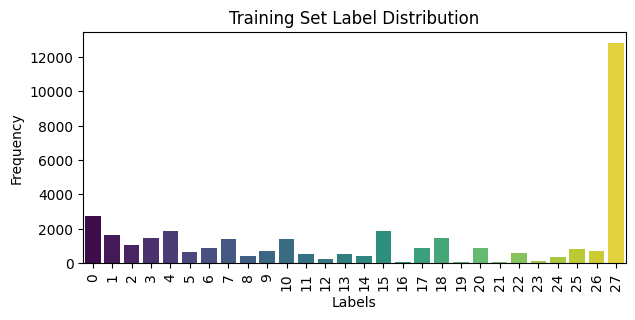


Distribution - Validation Set


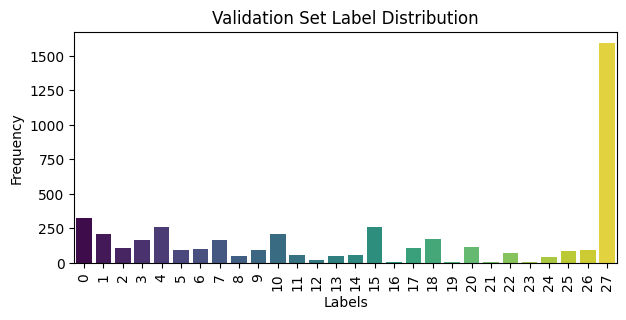


Distribution - Test Set


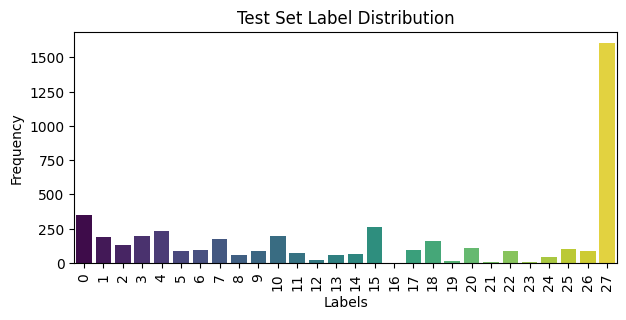

In [7]:
def plot_label_distribution(df, title):
    label_counts = df['labels'].value_counts().sort_index().reset_index()
    label_counts.columns = ['label', 'count']  # Rename columns for clarity

    plt.figure(figsize=(7, 3))
    sns.barplot(
        data=label_counts,
        x='label',
        y='count',
        palette="viridis",
        hue='label',  # Use label as the hue variable
        dodge=False  # Prevent separation of bars by hue
    )
    plt.title(f"{title} Label Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.legend([], [], frameon=False)  # Remove legend if unnecessary
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.show()

# Plot distributions for train, validation, and test
print("Distribution - Training Set")
plot_label_distribution(clean_train_df, "Training Set")
print("\nDistribution - Validation Set")
plot_label_distribution(clean_validation_df, "Validation Set")
print("\nDistribution - Test Set")
plot_label_distribution(clean_test_df, "Test Set")

In [8]:
# Aside: Here are the values of our labels
analysis_dataset = load_dataset("google-research-datasets/go_emotions", "simplified", split="train")

label_names = analysis_dataset.features['labels'].feature.names
label_mapping = {index: label for index, label in enumerate(label_names)}
print("Label Correspondence:")
for label, emotion in label_mapping.items():
  print(f"{label}: {emotion}")

README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Label Correspondence:
0: admiration
1: amusement
2: anger
3: annoyance
4: approval
5: caring
6: confusion
7: curiosity
8: desire
9: disappointment
10: disapproval
11: disgust
12: embarrassment
13: excitement
14: fear
15: gratitude
16: grief
17: joy
18: love
19: nervousness
20: optimism
21: pride
22: realization
23: relief
24: remorse
25: sadness
26: surprise
27: neutral


We can observe that the Neutral (27) emotion dominates significantly in each of our datasets. There is also a disproportionately small amount of grief (16), nervousness (19), pride (21) and relief (23) emotion entries.

#### Emoji Presence Analysis and Processing
Some of the sentences in our datasets contain emojis, which can't automatically be processed by functions like CountVectorizer by default. In this subsection, we will explore the presence of emojis in our dataset and the correct approach for handling them.

In [9]:
# Define a regex pattern to match emojis
emoji_pattern = re.compile(
    "[\U0001F600-\U0001F64F]"  # Emoticons
    "|[\U0001F300-\U0001F5FF]"  # Symbols & Pictographs
    "|[\U0001F680-\U0001F6FF]"  # Transport & Map Symbols
    "|[\U0001F700-\U0001F77F]"  # Alchemical Symbols
    "|[\U0001F780-\U0001F7FF]"  # Geometric Shapes Extended
    "|[\U0001F800-\U0001F8FF]"  # Supplemental Arrows-C
    "|[\U0001F900-\U0001F9FF]"  # Supplemental Symbols & Pictographs
    "|[\U0001FA00-\U0001FA6F]"  # Chess Symbols
    "|[\U0001FA70-\U0001FAFF]"  # Symbols and Pictographs Extended-A
    "|[\U00002702-\U000027B0]"  # Dingbats
    "|[\U000024C2-\U0001F251]"  # Enclosed Characters
    "]+", flags=re.UNICODE
)

# Function to calculate percentage of sentences containing emojis
def calculate_emoji_percentage(df):
    total_sentences = len(df)
    emoji_sentences = df['text'].apply(lambda x: bool(emoji_pattern.search(x))).sum()
    return (emoji_sentences / total_sentences) * 100

# Calculate percentages for each split
train_emoji_percentage = calculate_emoji_percentage(train_df)
validation_emoji_percentage = calculate_emoji_percentage(validation_df)
test_emoji_percentage = calculate_emoji_percentage(test_df)

# Print the results
print(f"Percentage of sentences with emojis in the training set: {train_emoji_percentage:.2f}%")
print(f"Percentage of sentences with emojis in the validation set: {validation_emoji_percentage:.2f}%")
print(f"Percentage of sentences with emojis in the test set: {test_emoji_percentage:.2f}%")


Percentage of sentences with emojis in the training set: 1.81%
Percentage of sentences with emojis in the validation set: 1.94%
Percentage of sentences with emojis in the test set: 1.82%


Since our label values don't contain any "confidence" property, we don't gain much benefit by including sentences with emojis that may have more "obvious" emotions associated with them. Therefore, to avoid implementing complex preprocessing, we will simply remove all entries containing emojis.
- We believe this is an optimal solution as opposed to e.g. simply ignoring emoji values, given the fact that their removal could unintentionally change the "tone" or "emotion" of a given sentence.

In [10]:
print(f"Current training set size: {len(clean_train_df)}")
print(f"Current validation set size: {len(clean_validation_df)}")
print(f"Current test set size: {len(clean_test_df)} \n\n")

# Function to filter out rows containing emojis
def remove_sentences_with_emojis(df):
    # Filter dataframe to keep rows without emojis
    filtered_df = df[~df['text'].apply(lambda x: bool(emoji_pattern.search(x)))]
    return filtered_df

# Apply the function to each split
clean_train_df = remove_sentences_with_emojis(clean_train_df)
clean_validation_df = remove_sentences_with_emojis(clean_validation_df)
clean_test_df = remove_sentences_with_emojis(clean_test_df)

# Print the sizes of the cleaned datasets
print(f"Cleaned training set size: {len(clean_train_df)}")
print(f"Cleaned validation set size: {len(clean_validation_df)}")
print(f"Cleaned test set size: {len(clean_test_df)}")

Current training set size: 36308
Current validation set size: 4548
Current test set size: 4590 


Cleaned training set size: 35761
Cleaned validation set size: 4480
Cleaned test set size: 4526


As an additional check, we will visually inspect the new label distribution graph to see if any labels were disproportionally affected by this change.

Distribution - New training Set


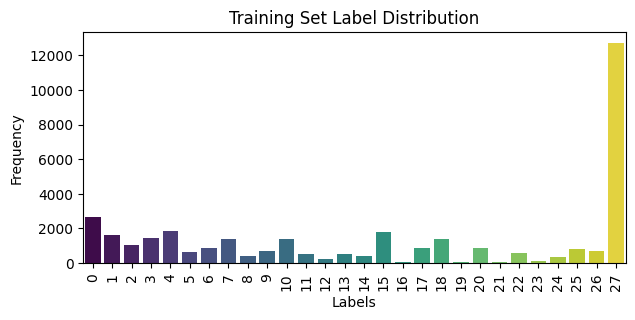

In [11]:
print("Distribution - New training Set")
plot_label_distribution(clean_train_df, "Training Set")

No significant change is observed in the distribution.

### **Baseline Model Preprocessing**

Now, we get the data into a numerical form that can be used within our methods/models by using vectorizers and tokenizers depending on the corresponding method/model.

In [12]:
#for baseline method
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

X_train_baseline = vectorizer.fit_transform(clean_train_df['text'])
y_train_baseline = clean_train_df['labels']

X_validation_baseline = vectorizer.transform(clean_validation_df['text'])
y_validation_baseline = clean_validation_df['labels']

X_test_baseline = vectorizer.transform(clean_test_df['text'])
y_test_baseline = clean_test_df['labels']


print(X_train_baseline)
#print(y_train_baseline)
#print(X_validation_baseline)
#print(y_validation_baseline)
#print(X_test_baseline)
#print(y_test_baseline)

  (0, 14056)	0.19416548544160825
  (0, 8034)	0.43095278770888484
  (0, 8530)	0.3725674472797036
  (0, 11427)	0.1495263893564067
  (0, 1405)	0.31195732413022775
  (0, 6186)	0.27296690194296064
  (0, 9969)	0.19681285229935178
  (0, 21701)	0.13137461496369116
  (0, 4935)	0.5129900387743498
  (0, 14058)	0.352750826135225
  (1, 14558)	0.18161127049997272
  (1, 10701)	0.15601923972960718
  (1, 9998)	0.14902837743572483
  (1, 6572)	0.21864915610863175
  (1, 14756)	0.212967673567374
  (1, 10217)	0.2951066628863722
  (1, 7596)	0.22684879856167214
  (1, 23608)	0.183716613345956
  (1, 21464)	0.17699964401695278
  (1, 10154)	0.3175227009820407
  (1, 9974)	0.23949173087050923
  (1, 12132)	0.2750767857957089
  (1, 18707)	0.36916828722215894
  (1, 23679)	0.14619572243199996
  (1, 15640)	0.16869568040526123
  :	:
  (35758, 9350)	0.2083897766115026
  (35758, 23464)	0.1833429449676686
  (35758, 14096)	0.2796113533555271
  (35758, 24043)	0.12420201667097809
  (35758, 21387)	0.12510829585424577
  (35758, 

### **Naive Bayes Preprocessing**

In [13]:
# Naive Bayes:
# Convert word data into numerical features using CountVectorizer
bayes_vectorizer = CountVectorizer()

x_train_bayes_sparse = bayes_vectorizer.fit_transform(clean_train_df['text'])
y_train_bayes = clean_train_df['labels']

# Ensure the validation and test sets use the same labels as those assigned to the train set.
x_validation_bayes_sparse = bayes_vectorizer.transform(clean_validation_df['text'])
y_validation_bayes = clean_validation_df['labels']

x_test_bayes_sparse = bayes_vectorizer.transform(clean_test_df['text'])
y_test_bayes = clean_test_df['labels']

# Note our GaussianBayes model work on dense arrays. We will therefore
# convert our training data into arrays of length

x_train_bayes = x_train_bayes_sparse.toarray()
x_validation_bayes = x_validation_bayes_sparse.toarray()
x_test_bayes = x_test_bayes_sparse.toarray()
print("Type of each feature entry", type(x_train_bayes[0]))
print("Length of each feature array:", len(x_train_bayes[0]))

#print(x_train_bayes)
#print(y_train_bayes)
#print(X_validation_bayes)
#print(y_validation_bayes)
#print(X_test_bayes)
#print(y_test_bayes)

Type of each feature entry <class 'numpy.ndarray'>
Length of each feature array: 24150


### **LLM BERT Preprocessing**

Tokenize each dataset and convert labels to torch tensors

In [14]:
PATH_TO_LLM = "google-bert/bert-base-uncased"
TOKENIZER_LLM = AutoTokenizer.from_pretrained(PATH_TO_LLM) # bert base uncased tokenizer

# Train - tokenize and convert labels to torch tensors
x_train_LLM = TOKENIZER_LLM(clean_train_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_LLM = torch.tensor(clean_train_df['labels'].values)

# Validation - tokenize and convert labels to torch tensors
x_validation_LLM = TOKENIZER_LLM(clean_validation_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
y_validation_LLM = torch.tensor(clean_validation_df['labels'].values)

# Test - tokenize and convert labels to torch tensors
x_test_LLM = TOKENIZER_LLM(clean_test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_LLM = torch.tensor(clean_test_df['labels'].values)


print(f"Training Features:\n{x_train_LLM['input_ids'].shape}\n{x_train_LLM}")
print(f"Training Labels:\n{y_train_LLM.shape}\n{y_train_LLM}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training Features:
torch.Size([35761, 316])
{'input_ids': tensor([[ 101, 2026, 8837,  ...,    0,    0,    0],
        [ 101, 2085, 2065,  ...,    0,    0,    0],
        [ 101, 2339, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2062, 2066,  ...,    0,    0,    0],
        [ 101, 5959, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
Training Labels:
torch.Size([35761])
tensor([27, 27,  2,  ...,  3, 13, 17])


### **Performance Evaluation Methods**
Functions developed to evaluate the performance of each model according to accuracy, f1 score, and a detailed overview using an enhanced version of sklearn.metrics' classification_report method.

In [15]:
# Basic Metrics (Acc, F1):
def compute_acc_and_f1(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')
  return acc, f1

# Detailed Overview of Model Performance
def enhanced_classification_report(y_true, y_pred):
  '''Produces & prints a table with detailed class-specific performance metrics
  (e.g. accuracy, f1, prec, recall) by enhancing the sklearn.metrics
  classification_report method.'''

  # sklearn's classification report as dict
  report_dict = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0)

  # Convert to df
  report_df = pd.DataFrame(report_dict).transpose()

  # Compute confusion matrix to get class-specific accs
  cm = confusion_matrix(y_true, y_pred)
  class_accuracies = cm.diagonal() / cm.sum(axis=1)

  # Add acc column to the DataFrame for each class
  for i, class_name in enumerate(report_df.index[:-3]):  # Exclude 'accuracy', 'macro avg', 'weighted avg'
      report_df.loc[class_name, 'accuracy'] = class_accuracies[i]

  # Reset index for better readability
  report_df = report_df.reset_index().rename(columns={'index': 'class'})

  # Format columsn to 4 decimal places
  numeric_cols = ['precision', 'recall', 'f1-score', 'support', 'accuracy']
  for col in numeric_cols:
    report_df[col] = report_df[col].astype(float).round(4)

  # Print the final table
  print(f"\n{report_df}\n")


## **Task 2A: Naive Bayes Model**

In the section below, we will implement a Naive Bayes model. This will include the following subsections:

* Preprocessed Data Analysis
* Helper Functions
* Example Model Class - Gaussian
* <u>Model Class - Multinomial</u>

### **Preprocessed Data Analysis**

In order for our Naive Bayes model to understand the structure of our text, we first have to convert it to a numerical representation. Using a bag-of-words representation converts our sentences into arrays of size len(sentence), where each element corresponds to an integer value corresponding to a singular word used within all training examples.

* In our data preprocessing phase, we have already converted our data into this representation and split it into (Feature/Target) Train/Test/Validation sets. We will further analyze them here.

In [16]:
# E.g. Comparison - Original train targets vs. processed train targets

original_train_targets = train_df["text"]
# E.g. Raw first, second and third sentences
print("Raw data feature examples:\n")
print(original_train_targets[0])
print("###")
print(original_train_targets[1])

print("\n\nUnprocessed data feature examples:\n")
# Processed first and second sentences
print(x_train_bayes_sparse[0])
print("###")
print(x_train_bayes_sparse[1])

# Identify what indices correspond to what word in the vectorizer
reverse_vocab = {index: word for word, index in bayes_vectorizer.vocabulary_.items()}

# Now you can print the word for a given index
# E.g.
print("Reverse vocabulary search examples: ")
print(reverse_vocab.get(14144))
print(reverse_vocab.get(10770))

print("\nLength: Sparse train dataset")
print(x_train_bayes_sparse.getnnz())


Raw data feature examples:

My favourite food is anything I didn't have to cook myself.
###
Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead


Unprocessed data feature examples:

  (0, 14056)	1
  (0, 8034)	1
  (0, 8530)	1
  (0, 11427)	1
  (0, 1405)	1
  (0, 6186)	1
  (0, 9969)	1
  (0, 21701)	1
  (0, 4935)	1
  (0, 14058)	1
###
  (0, 14558)	1
  (0, 10701)	1
  (0, 9998)	1
  (0, 6572)	1
  (0, 14756)	1
  (0, 10217)	1
  (0, 7596)	1
  (0, 23608)	1
  (0, 21464)	1
  (0, 10154)	1
  (0, 9974)	1
  (0, 12132)	1
  (0, 18707)	1
  (0, 23679)	1
  (0, 15640)	1
  (0, 11194)	1
  (0, 14752)	1
  (0, 773)	1
  (0, 5644)	1
Reverse vocabulary search examples: 
nationalist
imitates

Length: Sparse train dataset
403012


In [17]:
# Note: Our labels are integer-valued, which is also easy to process for Naive Bayes
print(type(y_train_bayes[0]))

<class 'numpy.int64'>


### **Helper Functions**

We use the log-sum-exp trick to help normalize our data and avoid numerical instability isues.

$$
\log p(y=c|x) =  (\log \tilde{p}(y=c| x)) - \log \left (\sum_{c'} \exp (\log \tilde{p}(y=c| x)) \right )
$$


In [18]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

### **Example Model Class - Gaussian**

From the course notes, we were provided with an implementaion of Gaussian Naive Bayes. This type of model is designed for continuous input feature data, with each feature being passed in as a dense array of data points.

* Since our features are categorical (bag-of-words representation), this model is not optimal for our input data.

In [19]:
class GaussianNaiveBayes:

    def __init__(self):
        return

    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            mu[c,:] = np.mean(x_c,0)                  #mean of features of class c
            sigma[c,:] = np.std(x_c, 0)               #std of features of class c

        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

    def predict(self, xt):
        Nt, D = xt.shape
        # for numerical stability we work in the log domain
        # we add a dimension because this is added to the log-likelihood matrix
        # that assigns a likelihood for each class (C) to each test point, and so it is C x N
        log_prior = np.log(self.pi)[:, None]
        # logarithm of the likelihood term for Gaussian
        # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian.
        # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation.
        # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
        log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:] + 1e-10) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
        # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
        log_likelihood = np.sum(log_likelihood, axis=2)
        # posterior calculation
        log_posterior = log_prior + log_likelihood
        posterior = np.exp(log_posterior - logsumexp(log_posterior))
        return posterior.T                                                  # dimension N x C

#### **Example Usage - Continuous Features**

In [20]:
# Test: Using Gaussian Naive Bayes to make predictions on IRIS dataset data

from sklearn import model_selection
from sklearn import datasets
x, y = datasets.load_iris(return_X_y=True)
x = x[:, :2]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2) # this is similar to our manual split above
model = GaussianNaiveBayes()
model.fit(x_train, y_train)
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = np.sum(y_pred == y_test)/y_pred.shape[0]
print(f'test accuracy: {accuracy}')

print("Dataset shape - Features:", type(x[0]))
print("Examples - Features")
print(x[0])
print(x[1])

print("Dataset shape - Targets", type(y[0]))
print("Examples - Targets")
print(y[0])
print(y[1])

test accuracy: 0.8
Dataset shape - Features: <class 'numpy.ndarray'>
Examples - Features
[5.1 3.5]
[4.9 3. ]
Dataset shape - Targets <class 'numpy.int64'>
Examples - Targets
0
0


### **Model Class - Multinomial**

Since our input data encodes the frequency of word occurrences in each sentence, we will assume our word counts are drawn from a multinomial distribution.

- This will ensure that word counts, and not just word occurrences in a sentence (e.g. the sentence "This is very very very good) contribute to its classification.
- We also create our model to support sparse matrix input data, i.e. the format we achieved by converting our features using the CountVectorizer() class.


In [21]:
class MultinomialNaiveBayes:
  def __init__(self, has_laplace_smoothing = True, alpha = 1, is_verbose=False):
    self.has_laplace_smoothing = has_laplace_smoothing
    self.alpha = alpha
    self.is_verbose = is_verbose

  def fit(self, x, y):
    N, D = x.shape
    C = np.max(y) + 1 # Number of unique classes
    if self.is_verbose:
      print("Training data has shape (rows, columns): ", N, D)
      print("Identified", C, "classes.")

    V = D # Vocabulary size, i.e. number of unique words / valid symbols

    # Init variables
    self.theta = np.zeros((C, V)) # Store word probabilities for each class.
    # I.e. for each class c and each word i, calculate p(word_i | class_c)

    self.pi = np.zeros(C) # Class priors, i.e. prior belief that a sample belongs to some class c

    if self.is_verbose:
      print("\nInitialized Theta array with dimensions (row, column):", self.theta.shape)
      print("Initialized Pi array with dimensions (row, column):", self.pi.shape)

    class_counts = np.zeros(C) # Will count num of words in each class
    word_counts = np.zeros((C, V)) # How many times each individual word appears in each individual class

    for c in range(C):
      # For each class, get all rows fitting that specific class
      x_c = x[y == c]
      class_counts[c] = x_c.shape[0]
      word_counts[c, :] = x_c.sum(axis=0)

    if self.is_verbose:
      print("\nNumber of instances in each class:", class_counts)
      print("E.g. Number of word occurrences (word_id = 0, 1, ..., 9) in class 27:", word_counts[27][:10])

    if self.has_laplace_smoothing:
      self.pi = (class_counts + self.alpha) / (N + C) # Laplace smoothing
    else:
      self.pi = class_counts / N

    # Populate theta
    for c in range(C):
      total_words_in_class = word_counts[c].sum()
      if self.has_laplace_smoothing:
        self.theta[c, :] = (word_counts[c] + self.alpha) / (total_words_in_class + V) # Laplace smoothing
      else:
        self.theta[c, :] = word_counts[c] / total_words_in_class

    if self.is_verbose:
      print("\nInitialized pi to:", self.pi)
      print("Theta sample:", self.theta[27][:10])

    return self


  def predict(self, x):
    N, D = x.shape

    # For numerical stability, work in log-domain.
    log_prior = np.log(self.pi)[None, :] # Log priors, of dimension (1, C)

    # Compute log-likelihood for each class
    # I.e. log(P(word | class)) for each word. (N x V)
    log_likelihood = np.dot(x, np.log(self.theta.T))

    if self.is_verbose:
      print("\nComputed log prior of dimensions:", log_prior.shape)
      print("Computed log likelihood of dimensions:", log_likelihood.shape)

    log_posterior = log_prior + log_likelihood # (N x C)

    # Normalize using logsumexp to avoid numerical overflow/underflow
    log_sum_exp = np.log(np.sum(np.exp(log_posterior), axis=1))[:, None]  # shape (N, 1)
    log_posterior -= log_sum_exp

    posterior = np.exp(log_posterior) # (N x C)

    if self.is_verbose:
      print("\nComputed posterior probability of dimensions:", posterior.shape)

    return posterior

  @staticmethod
  def evaluate_avg_acc(y, y_pred):
    return np.mean(y == y_pred)

  @staticmethod
  def compute_class_accuracies(y, y_pred):
    """
    Computes accuracy for each class individually.

    Parameters:
    - y: np.ndarray, true labels
    - y_pred: np.ndarray, predicted labels

    Returns:
    - dict, mapping of class label to its accuracy
    """
    unique_classes = np.unique(y)  # Ensure unique classes are derived from y_true
    class_accuracies = {}

    for c in unique_classes:
        # Boolean mask for the current class
        mask = y == c
        # Accuracy for this class
        class_accuracy = np.mean(y_pred[mask] == y[mask]) * 100
        class_accuracies[c] = class_accuracy

    return class_accuracies



#### Example Usage
Below, we will go through an example of how to use the model class and its accuracy evaluation methods on our preprocessed data.

In [22]:
# Model initialization - We will evaluate accuracy on training data.
multinom_bayes = MultinomialNaiveBayes(has_laplace_smoothing=True, alpha=1, is_verbose = True)
multinom_bayes.fit(x_train_bayes_sparse, y_train_bayes)
train_predictions = multinom_bayes.predict(x_train_bayes)


Training data has shape (rows, columns):  35761 24150
Identified 28 classes.

Initialized Theta array with dimensions (row, column): (28, 24150)
Initialized Pi array with dimensions (row, column): (28,)

Number of instances in each class: [ 2663.  1615.  1016.  1439.  1834.   640.   852.  1363.   375.   702.
  1387.   495.   201.   492.   420.  1809.    37.   841.  1376.    85.
   841.    51.   573.    88.   352.   790.   705. 12719.]
E.g. Number of word occurrences (word_id = 0, 1, ..., 9) in class 27: [ 6. 14.  0.  1.  1.  0.  1.  0.  2.  1.]

Initialized pi to: [0.07443628 0.04515354 0.02841655 0.04023583 0.05127274 0.01791053
 0.02383414 0.03811227 0.01050602 0.01964291 0.03878287 0.01385901
 0.00564419 0.01377518 0.01176339 0.0505742  0.00106178 0.02352678
 0.03847551 0.00240297 0.02352678 0.00145296 0.01603845 0.0024868
 0.00986337 0.02210176 0.01972673 0.35541647]
Theta sample: [3.99226641e-05 8.55485659e-05 5.70323773e-06 1.14064755e-05
 1.14064755e-05 5.70323773e-06 1.14064755

In [23]:
# We can now use our accuracy evaluation methods to analyse the accuracy of the model's predictions.
predicted_labels = np.argmax(train_predictions, axis=1)

print(MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, predicted_labels))
print("\n")

class_accuracies = MultinomialNaiveBayes.compute_class_accuracies(y_train_bayes, predicted_labels)
print("Class-wise accuracies:")
for cls, acc in class_accuracies.items():
    if acc is not None:
        print(f"Class {cls}: {acc:.2f}%")
    else:
        print(f"Class {cls}: No samples available")


0.49145717401638656


Class-wise accuracies:
Class 0: 54.98%
Class 1: 33.93%
Class 2: 14.17%
Class 3: 9.73%
Class 4: 12.81%
Class 5: 2.34%
Class 6: 3.40%
Class 7: 9.10%
Class 8: 2.40%
Class 9: 3.56%
Class 10: 8.22%
Class 11: 7.47%
Class 12: 1.00%
Class 13: 3.25%
Class 14: 3.57%
Class 15: 71.37%
Class 16: 0.00%
Class 17: 12.25%
Class 18: 35.47%
Class 19: 0.00%
Class 20: 11.18%
Class 21: 0.00%
Class 22: 2.09%
Class 23: 0.00%
Class 24: 5.40%
Class 25: 7.47%
Class 26: 7.94%
Class 27: 98.56%


### Hyperparameter tuning

Although there anen't many distinct hyperparameters tunable in our model, we can analyse the effect of including Laplace Smoothing vs. Not including it, as well as its strength (which we will denote Alpha).

As a reminder, the main objective of Laplace smoothing is to address the problem of zero probabilities, which can lead to zero-probability outputs unneccessarily.

We will use our validation set to analyse the effect of Laplace Smoothing and its strength on the model's predictions.

In [24]:
# Initialize two models - One with smoothing and one without
multinom_bayes_0 = MultinomialNaiveBayes(has_laplace_smoothing=False, alpha=0, is_verbose = False)
multinom_bayes_1 = MultinomialNaiveBayes(has_laplace_smoothing=True, alpha=1, is_verbose = False)
multinom_bayes_5 = MultinomialNaiveBayes(has_laplace_smoothing=True, alpha=5, is_verbose = False)
multinom_bayes_10 = MultinomialNaiveBayes(has_laplace_smoothing=True, alpha=10, is_verbose = False)
# Train both models on our training set
multinom_bayes_0.fit(x_train_bayes_sparse, y_train_bayes)
multinom_bayes_1.fit(x_train_bayes_sparse, y_train_bayes)
multinom_bayes_5.fit(x_train_bayes_sparse, y_train_bayes)
multinom_bayes_10.fit(x_train_bayes_sparse, y_train_bayes)


# Compute prediction accuracies
train_pred_accuracies, validation_pred_accuracies = [], []


### Train Predictions ###
train_predictions_0 = multinom_bayes_0.predict(x_train_bayes)
train_predicted_labels_0 = np.argmax(train_predictions_0, axis=1)
train_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels_0)
    )

train_predictions_1 = multinom_bayes_1.predict(x_train_bayes)
train_predicted_labels_1 = np.argmax(train_predictions_1, axis=1)
train_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels_1)
    )

train_predictions_5 = multinom_bayes_5.predict(x_train_bayes)
train_predicted_labels_5 = np.argmax(train_predictions_5, axis=1)
train_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels_5)
    )

train_predictions_10 = multinom_bayes_10.predict(x_train_bayes)
train_predicted_labels_10 = np.argmax(train_predictions_10, axis=1)
train_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels_10)
    )



### Test Predictions ###
validation_predictions_0 = multinom_bayes_0.predict(x_validation_bayes)
validation_predicted_labels_0 = np.argmax(validation_predictions_0, axis=1)
validation_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_validation_bayes, validation_predicted_labels_0)
    )

validation_predictions_1 = multinom_bayes_1.predict(x_validation_bayes)
validation_predicted_labels_1 = np.argmax(validation_predictions_1, axis=1)
validation_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_validation_bayes, validation_predicted_labels_1)
    )

validation_predictions_5 = multinom_bayes_5.predict(x_validation_bayes)
validation_predicted_labels_5 = np.argmax(validation_predictions_5, axis=1)
validation_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_validation_bayes, validation_predicted_labels_5)
    )

validation_predictions_10 = multinom_bayes_10.predict(x_validation_bayes)
validation_predicted_labels_10 = np.argmax(validation_predictions_10, axis=1)
validation_pred_accuracies.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_validation_bayes, validation_predicted_labels_10)
    )



print("Train prediction accuracies:", train_pred_accuracies)
print("Validation prediction accuracies:", validation_pred_accuracies)

<ipython-input-21-37ed0ac58188>:67: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.dot(x, np.log(self.theta.T))


Train prediction accuracies: [0.0744665976902212, 0.49145717401638656, 0.48292832974469396, 0.46578675092978383]
Validation prediction accuracies: [0.07209821428571428, 0.43125, 0.4435267857142857, 0.4419642857142857]


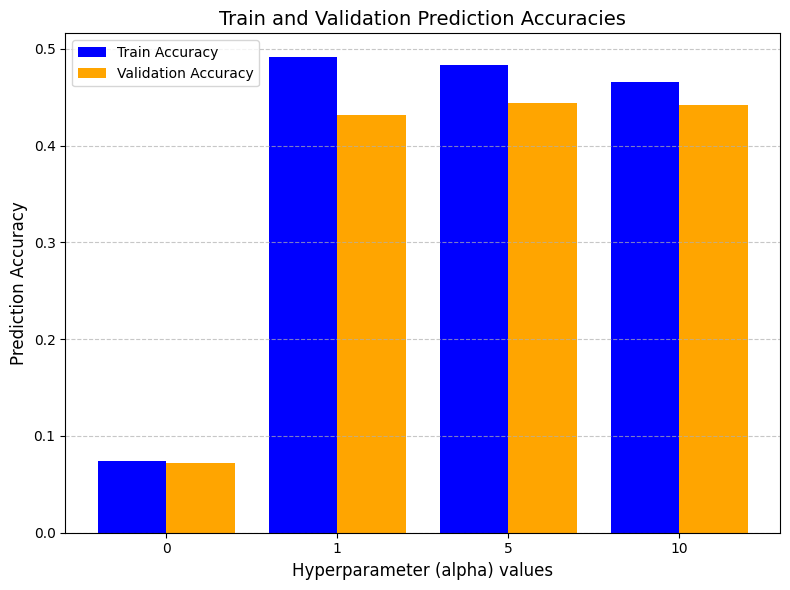

In [25]:
alphas = ["0", "1", "5", "10"]  # Labels for bar groups

# Parameters for the bar chart
x = np.arange(len(alphas))  # x positions for groups
bar_width = 0.4  # Width of each bar
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars
ax.bar(x - bar_width/2, train_pred_accuracies, width=bar_width, label='Train Accuracy', color='blue')
ax.bar(x + bar_width/2, validation_pred_accuracies, width=bar_width, label='Validation Accuracy', color='orange')

# Customize the chart
ax.set_xlabel('Hyperparameter (alpha) values', fontsize=12)
ax.set_ylabel('Prediction Accuracy', fontsize=12)
ax.set_title('Train and Validation Prediction Accuracies', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(alphas)
ax.legend()

# Show grid and plot
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Analysis**

We can observe that increasing the Laplace regularization strength (alpha) acts like a sort of regularization for the model, gradually decreasing the accuracy on the training set but reaching an optimal validation test accuracy around alpha = 5

We will therefore choose an alpha value of 5 as our optimal hyperparameter for Laplace smoothing.

## **Task 2B: LLM (BERT)**

In this subsection, we will be implementing two BERT LLMs, one will be the base pre-trained model, and the other will be a finetuned version of the former. This will allow us to compare the finetuned LLM to the version with finetuning, as well as against our Naive Bayes implementation and our baseline model.

#### **Preprocessing and configuration**

In [26]:
# Combine the input_ids, attention_masks, and labels from the tokenizer into one dataset
train_dataset_LLM = TensorDataset(x_train_LLM['input_ids'], x_train_LLM['attention_mask'], y_train_LLM)
validation_dataset_LLM = TensorDataset(x_validation_LLM['input_ids'], x_validation_LLM['attention_mask'], y_validation_LLM)
test_dataset_LLM = TensorDataset(x_test_LLM['input_ids'], x_test_LLM['attention_mask'], y_test_LLM)

# General Configuration
NUM_LABELS = len(clean_train_df['labels'].unique())
#model = AutoModelForSequenceClassification.from_pretrained(PATH_TO_LLM, num_labels=NUM_LABELS, output_attentions=True) # Load model
#print(f"\nReconfigured model to account for {NUM_LABELS} labels - output size: \n\t{model.classifier}")  # Show current output size (2)

#### **LLM without Finetuning**
Load the pretrained model for sequence classification, leaving as is.

In [27]:
class PretrainedLLM():
  '''This is the pretrained BERT LLM with no additional finetuning. As we are not training it
  on our GoEmotion dataset, this class includes a predict_and_eval() method to test the model
  on the validation and test sets.'''

  def __init__(self, tokenizer, verbose=False, output_attentions=False):
    self.verbose = verbose
    self.tokenizer = tokenizer
    self.output_attentions = output_attentions
    self.model = AutoModelForSequenceClassification.from_pretrained(PATH_TO_LLM, num_labels=NUM_LABELS, output_attentions=self.output_attentions) # Load model
    self.device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
    self.model.to(self.device) # Move to GPUs if available
    if self.verbose:
      print("Device:", self.device)

    self.attentions = None


  def predict(self, data_loader, num_examples=0):
    # Switch to eval mode
    self.model.eval()

    y_preds = []
    y_true = []

    # Collect data for attention analysis if needed
    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
      for batch in data_loader:
        input_ids = batch[0].to(self.device)
        attention_mask = batch[1].to(self.device)
        labels = batch[2].to(self.device)

        # Forward pass
        outputs = self.model(input_ids, attention_mask=attention_mask,
                             labels=labels, output_attentions=self.output_attentions)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        y_preds.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        attentions = outputs.attentions  # tuple of attention matrices


        # Collect attention examples if needed:
        if self.output_attentions and num_examples > 0:
          self.attentions = attentions

          # Iter over batch to collect examples
          for i in range(len(labels)):

            is_correct = (predictions[i] == labels[i])  # is the pred correct?

            # Collect attentions for correct examples:
            if is_correct and len(correct_examples) < num_examples:
              example_data = {
                'input_ids': input_ids[i].cpu(),
                'attention_mask': attention_mask[i].cpu(),
                'label': labels[i].cpu(),
                'prediction': predictions[i].cpu(),
                'attentions': [layer[i].cpu() for layer in attentions]
              }
              correct_examples.append(example_data)



            # Collect attentions for incorrect exmaples:
            elif not is_correct and len(incorrect_examples) < num_examples:
              example_data = {
                  'input_ids': input_ids[i].cpu(),
                  'attention_mask': attention_mask[i].cpu(),
                  'label': labels[i].cpu(),
                  'prediction': predictions[i].cpu(),
                  'attentions': [layer[i].cpu() for layer in attentions]
              }
              incorrect_examples.append(example_data)

              # break if enough examples collected
            if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
              break

    return y_true, y_preds, correct_examples, incorrect_examples

  @staticmethod
  def compute_acc_and_f1(y_true, y_preds):
    acc = accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds, average='weighted')
    return acc, f1

  @staticmethod
  def enhanced_classification_report(y_true, y_pred):
    '''Produces & prints a table with detailed class-specific performance metrics
    (e.g. accuracy, f1, prec, recall) by enhancing the sklearn.metrics
    classification_report method.'''

    # sklearn's classification report as dict
    report_dict = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

    # Convert to df
    report_df = pd.DataFrame(report_dict).transpose()

    # Compute confusion matrix to get class-specific accs
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)


    # Add acc column to the DataFrame for each class
    for i, class_name in enumerate(report_df.index[:-3]):  # Exclude 'accuracy', 'macro avg', 'weighted avg'
        report_df.loc[class_name, 'accuracy'] = class_accuracies[i]

    # Reset index for better readability
    report_df = report_df.reset_index().rename(columns={'index': 'class'})

    # Print the final table
    print(report_df)



#### **LLM with Finetuning**

In [28]:
class FinetunedLLM(PretrainedLLM):

  def __init__(self, tokenizer, lr, epochs, verbose=False, output_attentions=False, trainable_layers=[10,11]):
    super().__init__(tokenizer, verbose, output_attentions)
    self.model.to(self.device) # Move to GPUs if available

    # Freeze all layers in the model
    for param in self.model.parameters():
      param.requires_grad = False

    # Unfreeze the specified layers (last 2 layers 10 and 11)
    for layer_idx in trainable_layers:
      for param in self.model.bert.encoder.layer[layer_idx].parameters():
        param.requires_grad = True

    # Always unfreeze the classification head
    for param in self.model.classifier.parameters():
      param.requires_grad = True

    self.loss_fn = nn.CrossEntropyLoss()
    self.scheduler = None  # defined after knowing num of iterations

    # Hyperparams:
    self.learning_rate = lr
    self.num_epochs = epochs

    self.optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.learning_rate) # AdamWarmup, but skip over all frozen layers


  def train_LLM(self, train_loader):
    total_iterations = len(train_loader) * self.num_epochs #iters = num_batches * num_epochs

    self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_iterations)

    self.model.train() # set to training mode

    for epoch in range(self.num_epochs):
      total_loss = 0
      for batch in train_loader:
        self.model.zero_grad()

        input_ids = batch[0].to(self.device)
        attention_mask = batch[1].to(self.device)
        labels = batch[2].to(self.device)

        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()

      avg_train_loss = total_loss / len(train_loader)

      if self.verbose:
        print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {avg_train_loss:.4f}")


#### **Example Usage**

**Pretrained LLM**

In [34]:
model_pretrained = PretrainedLLM(TOKENIZER_LLM, verbose=True)
validation_loader1 = DataLoader(validation_dataset_LLM, batch_size=64, shuffle=False)

y, y_preds, *_ = model_pretrained.predict(validation_loader1)
acc, f1 = model_pretrained.compute_acc_and_f1(y, y_preds)

print("Pretrained model without finetuning:")
print(f"\tValidation Accuracy Score: {acc:.4f}")
print(f"\tValidation F1 Score: {f1:.4f}")

enhanced_classification_report(y, y_preds)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Pretrained model without finetuning:
	Validation Accuracy Score: 0.2705
	Validation F1 Score: 0.1691

             class  precision  recall  f1-score    support  accuracy
0       admiration     0.0417  0.0031    0.0058   323.0000    0.0031
1        amusement     0.0000  0.0000    0.0000   204.0000    0.0000
2            anger     0.0000  0.0000    0.0000   108.0000    0.0000
3        annoyance     0.0723  0.0366    0.0486   164.0000    0.0366
4         approval     0.0000  0.0000    0.0000   253.0000    0.0000
5           caring     0.0000  0.0000    0.0000    95.0000    0.0000
6        confusion     0.0000  0.0000    0.0000   102.0000    0.0000
7        curiosity     0.0000  0.0000    0.0000   163.0000    0.0000
8           desire     0.0000  0.0000    0.0000    51.0000    0.0000
9   disappointment     0.0000  0.0000    0.0000    91.0000    0.0000
10     disapproval     0.0000  0.0000    0.0000   208.0000    0.0000
11         disgust     0.0000  0.0000    0.0000    59.000

**Finetuned LLM**

In [36]:
# NOTE: Sample of 0.5 on T4 GPUs takes 15min, 0.33 takes 5min.
### Sample the Dataset & Preprocess the Dataset to test the model

def sample_dataset(sample_frac):
  sampled_clean_train_df = clean_train_df.sample(frac=sample_frac, random_state=42)
  sampled_clean_validation_df = clean_validation_df.sample(frac=sample_frac, random_state=42)

  # Tokenization using the sampled DataFrames
  x_train_sample = TOKENIZER_LLM(sampled_clean_train_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
  y_train_sample = torch.tensor(sampled_clean_train_df['labels'].values)

  x_validation_sample = TOKENIZER_LLM(sampled_clean_validation_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
  y_validation_sample = torch.tensor(sampled_clean_validation_df['labels'].values)

  # Combine the input_ids, attention_masks, and labels from the tokenizer into one dataset
  train_sample = TensorDataset(x_train_sample['input_ids'], x_train_sample['attention_mask'], y_train_sample)
  validation_sample = TensorDataset(x_validation_sample['input_ids'], x_validation_sample['attention_mask'], y_validation_sample)

  # Load into DataLoaders
  train_loader = DataLoader(train_sample, batch_size=64, shuffle=True)
  validation_loader = DataLoader(validation_sample, batch_size=64, shuffle=False)

  return train_loader, validation_loader



# Define Model:
sample_frac = 0.33
train_loader2, validation_loader2 = sample_dataset(sample_frac)
finetuned_model = FinetunedLLM(tokenizer=TOKENIZER_LLM, lr=2e-5, epochs=3, verbose=True)

# Train Model:
finetuned_model.train_LLM(train_loader2)

# Predict:
y_train, y_preds_train, *_ = finetuned_model.predict(train_loader2)
train_acc, train_f1 = compute_acc_and_f1(y_train, y_preds_train)

y_val, y_preds_val, *_ = finetuned_model.predict(validation_loader2)
val_accuracy, val_f1 = compute_acc_and_f1(y_val, y_preds_val)

# Print Results:
print(f"\nFinetune Model with {sample_frac} size sample of dataset:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\tValidation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

enhanced_classification_report(y_val, y_preds_val)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Epoch 1/3, Training Loss: 2.6927
Epoch 2/3, Training Loss: 2.2962
Epoch 3/3, Training Loss: 2.1569

Finetune Model with 0.33 size sample of dataset:
	Train Accuracy: 0.4558, Train F1 Score: 0.3205
	Validation Accuracy: 0.4526, Validation F1 Score: 0.3169

             class  precision  recall  f1-score    support  accuracy
0       admiration     0.4070  0.7043    0.5159   115.0000    0.7043
1        amusement     0.4000  0.0274    0.0513    73.0000    0.0274
2            anger     0.0000  0.0000    0.0000    31.0000    0.0000
3        annoyance     0.0000  0.0000    0.0000    50.0000    0.0000
4         approval     0.0000  0.0000    0.0000    68.0000    0.0000
5           caring     0.0000  0.0000    0.0000    32.0000    0.0000
6        confusion     0.0000  0.0000    0.0000    33.0000    0.0000
7        curiosity     0.2500  0.0536    0.0882    56.0000    0.0536
8           desire     0.0000  0.0000    0.0000    24.0000    0.0000
9   disappointment     0.0000  0.0000    

#### **Hyperparameter tuning**

Batch Size tuning for Finetuned LLM:

In [37]:
# Choosing HyperParams:

# Test out Batch sizes
sample_frac = 0.33
bs = [16, 32, 64, 128, 256]
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []


for batch_size in bs:
  # Load into DataLoaders:
  train_loader3, validation_loader3 = sample_dataset(sample_frac)
  finetuned_model = FinetunedLLM(tokenizer=TOKENIZER_LLM, lr=2e-5, epochs=3, verbose=True)

  # Train Model:
  start_time = time.time()
  finetuned_model.train_LLM(train_loader3)
  elapsed_time = time.time() - start_time

  # Predict:
  y_train, y_preds_train, *_ = finetuned_model.predict(train_loader3)
  train_acc, train_f1 = finetuned_model.compute_acc_and_f1(y_train, y_preds_train)
  y_val, y_preds_val, *_ = finetuned_model.predict(validation_loader3)
  val_accuracy, val_f1 = finetuned_model.compute_acc_and_f1(y_val, y_preds_val)

  # Store Results:
  train_accs.append(train_acc)
  train_f1s.append(train_f1)
  val_accs.append(val_accuracy)
  val_f1s.append(val_f1)

  # Print Results:
  print(f"\nFinetuned Model with batch size {batch_size}:")
  print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
  print(f"\tValidation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")
  print(f"\tTraining time: {elapsed_time}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/3, Training Loss: 2.7476
Epoch 2/3, Training Loss: 2.3349
Epoch 3/3, Training Loss: 2.1966

Finetuned Model with batch size 16:
	Train Accuracy: 0.4456, Train F1 Score: 0.3148
	Validation Accuracy: 0.4384, Validation F1 Score: 0.3116
	Training time: 57.546026945114136


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/3, Training Loss: 2.7386
Epoch 2/3, Training Loss: 2.3364
Epoch 3/3, Training Loss: 2.1804

Finetuned Model with batch size 32:
	Train Accuracy: 0.4500, Train F1 Score: 0.3162
	Validation Accuracy: 0.4384, Validation F1 Score: 0.3051
	Training time: 58.87260103225708


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/3, Training Loss: 2.6570
Epoch 2/3, Training Loss: 2.2697
Epoch 3/3, Training Loss: 2.1372

Finetuned Model with batch size 64:
	Train Accuracy: 0.4680, Train F1 Score: 0.3394
	Validation Accuracy: 0.4716, Validation F1 Score: 0.3435
	Training time: 59.5385582447052


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/3, Training Loss: 2.6889
Epoch 2/3, Training Loss: 2.2836
Epoch 3/3, Training Loss: 2.1632

Finetuned Model with batch size 128:
	Train Accuracy: 0.4479, Train F1 Score: 0.3047
	Validation Accuracy: 0.4520, Validation F1 Score: 0.3096
	Training time: 60.15813446044922


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/3, Training Loss: 2.7525
Epoch 2/3, Training Loss: 2.3480
Epoch 3/3, Training Loss: 2.1901

Finetuned Model with batch size 256:
	Train Accuracy: 0.4620, Train F1 Score: 0.3327
	Validation Accuracy: 0.4581, Validation F1 Score: 0.3303
	Training time: 59.65699315071106


In [38]:
# Test out Learning rates
sample_frac = 0.33
lrs = [7e-5, 5e-5, 3e-5, 2e-5]
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []


for rate in lrs:
  # Load into DataLoaders:
  train_loader3, validation_loader3 = sample_dataset(sample_frac)
  finetuned_model = FinetunedLLM(tokenizer=TOKENIZER_LLM, lr=rate, epochs=3, verbose=False) #i made verbose false here bc it was annoying me

  # Train Model:
  start_time = time.time()
  finetuned_model.train_LLM(train_loader3)
  elapsed_time = time.time() - start_time

  # Predict:
  y_train, y_preds_train, *_ = finetuned_model.predict(train_loader3)
  train_acc, train_f1 = finetuned_model.compute_acc_and_f1(y_train, y_preds_train)
  y_val, y_preds_val, *_ = finetuned_model.predict(validation_loader3)
  val_accuracy, val_f1 = finetuned_model.compute_acc_and_f1(y_val, y_preds_val)

  # Store Results:
  train_accs.append(train_acc)
  train_f1s.append(train_f1)
  val_accs.append(val_accuracy)
  val_f1s.append(val_f1)

  # Print Results:
  print(f"\nFinetuned Model with learning rate {rate}:")
  print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
  print(f"\tValidation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")
  print(f"\tTraining time: {elapsed_time}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with learning rate 7e-05:
	Train Accuracy: 0.5917, Train F1 Score: 0.5196
	Validation Accuracy: 0.5643, Validation F1 Score: 0.4862
	Training time: 60.20456838607788


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with learning rate 5e-05:
	Train Accuracy: 0.5454, Train F1 Score: 0.4465
	Validation Accuracy: 0.5291, Validation F1 Score: 0.4332
	Training time: 60.040165185928345


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with learning rate 3e-05:
	Train Accuracy: 0.5020, Train F1 Score: 0.3891
	Validation Accuracy: 0.4905, Validation F1 Score: 0.3763
	Training time: 59.696192026138306


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with learning rate 2e-05:
	Train Accuracy: 0.4654, Train F1 Score: 0.3298
	Validation Accuracy: 0.4662, Validation F1 Score: 0.3315
	Training time: 59.66688632965088


In [ ]:
# Test out epochs
sample_frac = 0.5
epochs_list = [2, 3, 4, 5, 7]
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []


for epoch in epochs_list:
  # Load into DataLoaders:
  train_loader3, validation_loader3 = sample_dataset(sample_frac)
  finetuned_model = FinetunedLLM(tokenizer=TOKENIZER_LLM, lr=2e-5, epochs=epoch, verbose=False) #i made verbose false here too

  # Train Model:
  start_time = time.time()
  finetuned_model.train_LLM(train_loader3)
  elapsed_time = time.time() - start_time

  # Predict:
  y_train, y_preds_train, *_ = finetuned_model.predict(train_loader3)
  train_acc, train_f1 = finetuned_model.compute_acc_and_f1(y_train, y_preds_train)
  y_val, y_preds_val, *_ = finetuned_model.predict(validation_loader3)
  val_accuracy, val_f1 = finetuned_model.compute_acc_and_f1(y_val, y_preds_val)

  # Store Results:
  train_accs.append(train_acc)
  train_f1s.append(train_f1)
  val_accs.append(val_accuracy)
  val_f1s.append(val_f1)

  # Print Results:
  print(f"\nFinetuned Model with {epoch} epochs:")
  print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
  print(f"\tValidation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")
  print(f"\tTraining time: {elapsed_time}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Finetuned Model with 2 epochs:
	Train Accuracy: 0.4751, Train F1 Score: 0.3527
	Validation Accuracy: 0.4705, Validation F1 Score: 0.3463
	Training time: 89.38085627555847


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with 3 epochs:
	Train Accuracy: 0.5073, Train F1 Score: 0.3995
	Validation Accuracy: 0.5058, Validation F1 Score: 0.3987
	Training time: 134.09955501556396


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with 4 epochs:
	Train Accuracy: 0.5270, Train F1 Score: 0.4249
	Validation Accuracy: 0.5263, Validation F1 Score: 0.4239
	Training time: 178.6836290359497


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with 5 epochs:
	Train Accuracy: 0.5527, Train F1 Score: 0.4743
	Validation Accuracy: 0.5518, Validation F1 Score: 0.4741
	Training time: 223.41314959526062


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Finetuned Model with 7 epochs:
	Train Accuracy: 0.5921, Train F1 Score: 0.5327
	Validation Accuracy: 0.5728, Validation F1 Score: 0.5089
	Training time: 312.99612617492676


**Analysis of Hyperparam performance:**

The above results demonstrate that the optimal hyperparameters for the finetuned model (batch size, learning rate, and number of epochs) are: 64, 7e-5, and 7 respectively.

## **Task 2C: Random Forest (Baseline Model)**

#### **Default configurations**

In [39]:
#Initialize the random forest classifier model with the default configurations

RF_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                                       max_samples=None, monotonic_cst=None)

In [40]:
#fit and print the accuracy of the default hyperparameters of the baseline model
RF_classifier.fit(X_train_baseline, y_train_baseline)

y_train_pred = RF_classifier.predict(X_train_baseline)
y_validation_pred = RF_classifier.predict(X_validation_baseline)

train_acc = accuracy_score(y_train_baseline, y_train_pred)
train_f1 = f1_score(y_train_baseline, y_train_pred, average='weighted')
val_acc = accuracy_score(y_validation_baseline, y_validation_pred)
val_f1 = f1_score(y_validation_baseline, y_validation_pred, average='weighted')

print(f"\nRandom Forest Classifier training set accuracy with default parameters: " + str(train_acc))
print(f"\nRandom Forest Classifier training set f1 score with default parameters: " + str(train_f1))
print(f"\nRandom Forest Classifier validation set accuracy with default parameters: " + str(val_acc))
print(f"\nRandom Forest Classifier validation set f1 score with default parameters: " + str(val_f1))


Random Forest Classifier training set accuracy with default parameters: 0.9962529012052236

Random Forest Classifier training set f1 score with default parameters: 0.9962511916921468

Random Forest Classifier validation set accuracy with default parameters: 0.5558035714285714

Random Forest Classifier validation set f1 score with default parameters: 0.4819924076242515


#### **Hyperparameter tuning**

Although the assignment stated we could simply use the default hyperparameters, in this subsection, we decided to experiment with some different hyperparameters for the sklearn Random Forest Classifer model. Many of the model's hyperparameters, even when significantly changed, did not heavily impact its performance within the context of this dataset. In the end, we chose to manipulate the first three hyperparameters: n_estimators, criterion, and max_depth.

In [41]:
# Choosing HyperParams:

# Test out n_estimator sizes (number of trees in the forest)
estimators = [1, 10, 50, 100, 150, 200]
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []

#REMOVE: can change max_depth to 10 to run faster for testing

for n in estimators:
  rf_classifier = RandomForestClassifier(n_estimators = n, criterion='gini', max_depth=None,
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                                       max_samples=None, monotonic_cst=None)

  # Train Model:
  start_time = time.time()
  rf_classifier.fit(X_train_baseline, y_train_baseline)
  # get predictions
  y_train_pred = rf_classifier.predict(X_train_baseline)
  y_validation_pred = rf_classifier.predict(X_validation_baseline)

  elapsed_time = time.time() - start_time
  train_acc = accuracy_score(y_train_baseline, y_train_pred)
  train_f1 = f1_score(y_train_baseline, y_train_pred, average='weighted')
  val_acc = accuracy_score(y_validation_baseline, y_validation_pred)
  val_f1 = f1_score(y_validation_baseline, y_validation_pred, average='weighted')

  # Store Results:
  train_accs.append(train_acc)
  train_f1s.append(train_f1)
  val_accs.append(val_acc)
  val_f1s.append(val_f1)

  # Print Results:
  print(f"\Random Forest Model with n_estimators {n}:")
  print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
  print(f"\tValidation Accuracy: {val_acc:.4f}, Validation F1 Score: {val_f1:.4f}")
  print(f"\tTraining time: {elapsed_time}")

\Random Forest Model with n_estimators 1:
	Train Accuracy: 0.7602, Train F1 Score: 0.7590
	Validation Accuracy: 0.3475, Validation F1 Score: 0.3380
	Training time: 1.5201270580291748
\Random Forest Model with n_estimators 10:
	Train Accuracy: 0.9841, Train F1 Score: 0.9841
	Validation Accuracy: 0.5272, Validation F1 Score: 0.4698
	Training time: 15.20197319984436
\Random Forest Model with n_estimators 50:
	Train Accuracy: 0.9961, Train F1 Score: 0.9961
	Validation Accuracy: 0.5533, Validation F1 Score: 0.4807
	Training time: 75.87069034576416
\Random Forest Model with n_estimators 100:
	Train Accuracy: 0.9963, Train F1 Score: 0.9963
	Validation Accuracy: 0.5558, Validation F1 Score: 0.4832
	Training time: 151.15810656547546
\Random Forest Model with n_estimators 150:
	Train Accuracy: 0.9963, Train F1 Score: 0.9963
	Validation Accuracy: 0.5540, Validation F1 Score: 0.4798
	Training time: 228.67172122001648
\Random Forest Model with n_estimators 200:
	Train Accuracy: 0.9963, Train F1 Sco

In [42]:
# Test out criterion
criteria = ['gini', 'entropy', 'log_loss']
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []

#REMOVE: can change max_depth to 10 to run faster for testing

for c in criteria:
  rf_classifier = RandomForestClassifier(n_estimators = 100, criterion=c, max_depth=None,
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                                       max_samples=None, monotonic_cst=None)


  # Train Model:
  start_time = time.time()
  rf_classifier.fit(X_train_baseline, y_train_baseline)
  # get predictions
  y_train_pred = rf_classifier.predict(X_train_baseline)
  y_validation_pred = rf_classifier.predict(X_validation_baseline)

  elapsed_time = time.time() - start_time
  train_acc = accuracy_score(y_train_baseline, y_train_pred)
  train_f1 = f1_score(y_train_baseline, y_train_pred, average='weighted')
  val_acc = accuracy_score(y_validation_baseline, y_validation_pred)
  val_f1 = f1_score(y_validation_baseline, y_validation_pred, average='weighted')

  # Store Results:
  train_accs.append(train_acc)
  train_f1s.append(train_f1)
  val_accs.append(val_acc)
  val_f1s.append(val_f1)

  # Print Results:
  print(f"Random Forest Model with criterion {c}:")
  print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
  print(f"\tValidation Accuracy: {val_acc:.4f}, Validation F1 Score: {val_f1:.4f}")
  print(f"\tTraining time: {elapsed_time}")

Random Forest Model with criterion gini:
	Train Accuracy: 0.9963, Train F1 Score: 0.9963
	Validation Accuracy: 0.5542, Validation F1 Score: 0.4820
	Training time: 151.43040776252747
Random Forest Model with criterion entropy:
	Train Accuracy: 0.9963, Train F1 Score: 0.9963
	Validation Accuracy: 0.5087, Validation F1 Score: 0.4197
	Training time: 196.03252243995667
Random Forest Model with criterion log_loss:
	Train Accuracy: 0.9963, Train F1 Score: 0.9963
	Validation Accuracy: 0.4993, Validation F1 Score: 0.4065
	Training time: 196.06623125076294


In [45]:
# Test out max_depth
depths = [1, 10, 50, 100, 150, 200, None]
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []

#REMOVE: can change n_estimators to 10 to run faster for testing

for d in depths:
  rf_classifier = RandomForestClassifier(n_estimators = 100, criterion=c, max_depth=d,
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                                       max_samples=None, monotonic_cst=None)
  # Train Model:
  start_time = time.time()
  rf_classifier.fit(X_train_baseline, y_train_baseline)
  # get predictions
  y_train_pred = rf_classifier.predict(X_train_baseline)
  y_validation_pred = rf_classifier.predict(X_validation_baseline)

  elapsed_time = time.time() - start_time
  train_acc = accuracy_score(y_train_baseline, y_train_pred)
  train_f1 = f1_score(y_train_baseline, y_train_pred, average='weighted')
  val_acc = accuracy_score(y_validation_baseline, y_validation_pred)
  val_f1 = f1_score(y_validation_baseline, y_validation_pred, average='weighted')

  # Store Results:
  train_accs.append(train_acc)
  train_f1s.append(train_f1)
  val_accs.append(val_acc)
  val_f1s.append(val_f1)

  # Print Results:
  print(f"Random Forest Model with max_depth {d}:")
  print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
  print(f"\tValidation Accuracy: {val_acc:.4f}, Validation F1 Score: {val_f1:.4f}")
  print(f"\tTraining time: {elapsed_time}")

Random Forest Model with max_depth 1:
	Train Accuracy: 0.3557, Train F1 Score: 0.1866
	Validation Accuracy: 0.3509, Validation F1 Score: 0.1823
	Training time: 0.9278421401977539
Random Forest Model with max_depth 10:
	Train Accuracy: 0.3557, Train F1 Score: 0.1866
	Validation Accuracy: 0.3509, Validation F1 Score: 0.1823
	Training time: 2.703885078430176
Random Forest Model with max_depth 50:
	Train Accuracy: 0.5690, Train F1 Score: 0.5266
	Validation Accuracy: 0.3911, Validation F1 Score: 0.2463
	Training time: 41.96160364151001
Random Forest Model with max_depth 100:
	Train Accuracy: 0.8947, Train F1 Score: 0.8956
	Validation Accuracy: 0.4770, Validation F1 Score: 0.3678
	Training time: 112.8801383972168
Random Forest Model with max_depth 150:
	Train Accuracy: 0.9614, Train F1 Score: 0.9616
	Validation Accuracy: 0.4917, Validation F1 Score: 0.3931
	Training time: 155.95892000198364
Random Forest Model with max_depth 200:
	Train Accuracy: 0.9829, Train F1 Score: 0.9829
	Validation Ac

*Analysis:*

 As we tested out multiple values for n_estimators (the number of trees in the random forest), we observed that the performance of the model improves on the validation set as n increases, but plateaus around 100, indicating that the default value is sufficient. Changing the criterion between gini, entropy, and log_loss showed no difference in the performance of the model. Finally, the default value of max_depth (None) also yielded the best performance. Overall, sklearn's default values are effective for the random forest classifier model.

## **Task 3: Experiments**
In this task, we test our models on the test set, compare each model's performance according to their Accuracy, F1 score, and class-wise accuracies.

### **3.1 - Classification Performance**

**Configuration**

In [46]:
test_accs = []  # Accuracy values
test_f1s = []   # F1-score values
num_examples = 2  # Number of Examples for sec 3.2:

#### **Pretrained LLM**

In [48]:
# Load Data:
test_loader_LLM = DataLoader(test_dataset_LLM, batch_size=32, shuffle=False)

# Load & eval model:
model_pretrained = PretrainedLLM(TOKENIZER_LLM, verbose=True, output_attentions=True)
y, y_preds, correct_pretrained, incorrect_pretrained = model_pretrained.predict(test_loader_LLM, num_examples) #collect attentions for 3.2
test_acc, test_f1 = compute_acc_and_f1(y, y_preds)

# Store results for comparison
test_accs.append(acc)
test_f1s.append(f1)

# Print Results
print("\nPretrained BERT Model Performance (without finetuning):")
print(f"\tTest Accuracy Score: {test_acc:.4f}")
print(f"\tTest F1 Score: {test_f1:.4f}\n")

enhanced_classification_report(y, y_preds)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda

Pretrained BERT Model Performance (without finetuning):
	Test Accuracy Score: 0.0656
	Test F1 Score: 0.0141


             class  precision  recall  f1-score    support  accuracy
0       admiration     0.0786  0.8070    0.1432   342.0000    0.8070
1        amusement     0.0000  0.0000    0.0000   179.0000    0.0000
2            anger     0.0000  0.0000    0.0000   130.0000    0.0000
3        annoyance     0.0000  0.0000    0.0000   192.0000    0.0000
4         approval     0.0000  0.0000    0.0000   230.0000    0.0000
5           caring     0.0000  0.0000    0.0000    86.0000    0.0000
6        confusion     0.0323  0.0208    0.0253    96.0000    0.0208
7        curiosity     0.0320  0.0398    0.0354   176.0000    0.0398
8           desire     0.0000  0.0000    0.0000    55.0000    0.0000
9   disappointment     0.0104  0.0114    0.0109    88.0000    0.0114
10     disapproval     0.0000  0.0000    0.0000   195.0000    0.0000
11         disgust     0.0000  0.0000    0.0000 

#### **Finetuned LLM**

In [49]:
# NOTE: 7 epochs takes 40 minutes
### Sample the Dataset & Preprocess the Dataset to test the model in Example Usage section.

# Chosen Hyperparams:       (chosen after testing on validation set:)
batch_size = 32
epochs = 7
lr = 7e-5

# Load Data:
train_loader_LLM = DataLoader(train_dataset_LLM, batch_size=batch_size, shuffle=True)
test_loader_LLM = DataLoader(test_dataset_LLM, batch_size=batch_size, shuffle=False)

# Define Model:
finetuned_model = FinetunedLLM(tokenizer=TOKENIZER_LLM, lr=lr, epochs=epochs, verbose=True, output_attentions=True)

# Train Model:
start_time = time.time()
finetuned_model.train_LLM(train_loader_LLM)
elapsed_time = time.time() - start_time
train_y, train_yh, *_ = finetuned_model.predict(train_loader_LLM)
train_acc, train_f1 = compute_acc_and_f1(y, y_preds)

# Predict:
test_y, test_yh, correct_finetuned, incorrect_finetuned = finetuned_model.predict(test_loader_LLM, num_examples) #collect attentions for 3.2
test_acc, test_f1 = compute_acc_and_f1(test_y, test_yh)


# Store results for comparison
test_accs.append(test_acc)
test_f1s.append(test_f1)

# Print Results:
print(f"\nFinetuned BERT Model Performance:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\tTest Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tHyperparam selection: Batch Size={batch_size}, Epochs:{epochs}, Adams' Learning Rate: {lr}")
print(f"\tTraining Time: {elapsed_time:2f}s\n")

enhanced_classification_report(test_y, test_yh)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/7, Training Loss: 1.7753
Epoch 2/7, Training Loss: 1.3769
Epoch 3/7, Training Loss: 1.2414
Epoch 4/7, Training Loss: 1.1273
Epoch 5/7, Training Loss: 1.0323
Epoch 6/7, Training Loss: 0.9483
Epoch 7/7, Training Loss: 0.8934

Finetuned BERT Model Performance:
	Train Accuracy: 0.0656, Train F1 Score: 0.0141
	Test Accuracy: 0.6098, Test F1 Score: 0.5976
	Hyperparam selection: Batch Size=32, Epochs:7, Adams' Learning Rate: 7e-05
	Training Time: 3437.783250s


             class  precision  recall  f1-score    support  accuracy
0       admiration     0.6375  0.7661    0.6959   342.0000    0.7661
1        amusement     0.7366  0.9218    0.8189   179.0000    0.9218
2            anger     0.4470  0.4538    0.4504   130.0000    0.4538
3        annoyance     0.3592  0.2656    0.3054   192.0000    0.2656
4         approval     0.4588  0.3391    0.3900   230.0000    0.3391
5           caring     0.5139  0.4302    0.4684    86.0000    0.4302
6        confusion     0.4419  0.3958

In [50]:
# Reprint with corrected train accuracies
train_acc, train_f1 = compute_acc_and_f1(train_y, train_yh)

# Print Results:
print(f"\nFinetuned BERT Model Performance:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\tTest Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tHyperparam selection: Batch Size={batch_size}, Epochs:{epochs}, Adams' Learning Rate: {lr}")
print(f"\tTraining Time: {elapsed_time:2f}s\n")

enhanced_classification_report(test_y, test_yh)


Finetuned BERT Model Performance:
	Train Accuracy: 0.7855, Train F1 Score: 0.7774
	Test Accuracy: 0.6098, Test F1 Score: 0.5976
	Hyperparam selection: Batch Size=32, Epochs:7, Adams' Learning Rate: 7e-05
	Training Time: 3437.783250s


             class  precision  recall  f1-score    support  accuracy
0       admiration     0.6375  0.7661    0.6959   342.0000    0.7661
1        amusement     0.7366  0.9218    0.8189   179.0000    0.9218
2            anger     0.4470  0.4538    0.4504   130.0000    0.4538
3        annoyance     0.3592  0.2656    0.3054   192.0000    0.2656
4         approval     0.4588  0.3391    0.3900   230.0000    0.3391
5           caring     0.5139  0.4302    0.4684    86.0000    0.4302
6        confusion     0.4419  0.3958    0.4176    96.0000    0.3958
7        curiosity     0.4691  0.5170    0.4919   176.0000    0.5170
8           desire     0.5952  0.4545    0.5155    55.0000    0.4545
9   disappointment     0.3585  0.2159    0.2695    88.0000    0.2159
10   

#### **Naive Bayes Model**
We will analyse the classification of our Naive Bayes model on the train and test sets through various metrics.

- Our tunable hyperparameter, alpha (representing the Laplace Smoothing strength), was determined to have an optimal value of 5.

- We will therefore measure the performance of our model on the train and test sets using this hyperparameter value.

In [52]:
# First, initialize a model and fit it on the training set

optimal_naive_bayes = MultinomialNaiveBayes(has_laplace_smoothing=True, alpha=5, is_verbose=False)

optimal_naive_bayes.fit(x_train_bayes_sparse, y_train_bayes) # Fit the model using our training set

train_predictions = optimal_naive_bayes.predict(x_train_bayes)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_accuracy = MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels)

test_predictions = optimal_naive_bayes.predict(x_test_bayes)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_accuracy = MultinomialNaiveBayes.evaluate_avg_acc(y_test_bayes, test_predicted_labels)

train_acc, train_f1 = compute_acc_and_f1(y_train_bayes, train_predicted_labels)
test_acc, test_f1 = compute_acc_and_f1(y_test_bayes, test_predicted_labels)

# Store results for comparison
test_accs.append(test_acc)
test_f1s.append(test_f1)

print(f"Naive Bayes Model:")
print(f"\tTrain accuracy: {train_acc:4f}")
print(f"\tTrain F1 score: {train_f1:4f}")
print(f"\tTest accuracy: {test_acc:4f}")
print(f"\tTest F1 score: {test_f1:4f}")
#print(f"\tTraining Time {elapsed_time:2f}s")

Naive Bayes Model:
	Train accuracy: 0.482928
	Train F1 score: 0.407277
	Test accuracy: 0.431507
	Test F1 score: 0.334777


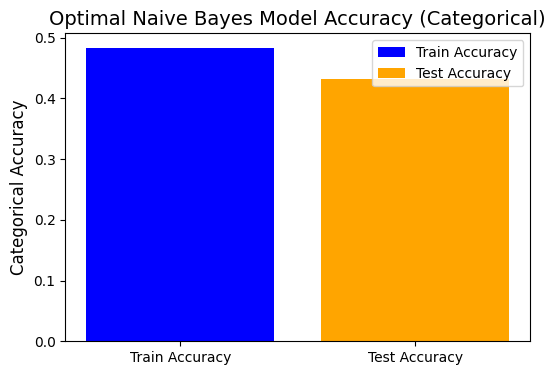

In [53]:
categories = ['Train Accuracy', 'Test Accuracy']
values = [train_accuracy, test_accuracy]

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(categories, values, color=['blue', 'orange'])

# Adding titles and labels
ax.set_title('Optimal Naive Bayes Model Accuracy (Categorical)', fontsize=14)
ax.set_ylabel('Categorical Accuracy', fontsize=12)
# Adding a legend
ax.legend(bars, ['Train Accuracy', 'Test Accuracy'], loc='upper right')

In [54]:
# Accuracy breakdown - Alternate metrics
print("ADVANCED METRICS - TRAIN SET\n")
enhanced_classification_report(y_train_bayes, train_predicted_labels)

print("\n\nADVANCED METRICS - TEST SET\n")
enhanced_classification_report(y_test_bayes, test_predicted_labels)

ADVANCED METRICS - TRAIN SET


             class  precision  recall  f1-score     support  accuracy
0       admiration     0.5613  0.6117    0.5854   2663.0000    0.6117
1        amusement     0.7630  0.4464    0.5633   1615.0000    0.4464
2            anger     0.6198  0.1476    0.2385   1016.0000    0.1476
3        annoyance     0.5151  0.1306    0.2084   1439.0000    0.1306
4         approval     0.4580  0.1696    0.2475   1834.0000    0.1696
5           caring     0.4651  0.0312    0.0586    640.0000    0.0312
6        confusion     0.5714  0.0516    0.0947    852.0000    0.0516
7        curiosity     0.5309  0.1262    0.2039   1363.0000    0.1262
8           desire     0.8462  0.0293    0.0567    375.0000    0.0293
9   disappointment     0.8788  0.0413    0.0789    702.0000    0.0413
10     disapproval     0.4851  0.1175    0.1892   1387.0000    0.1175
11         disgust     0.7576  0.0505    0.0947    495.0000    0.0505
12   embarrassment     0.0000  0.0000    0.0000    201.0000

**Analysis**

1. Accuracy score varies significantly by class: Observe that classes with high support (i.e. occurrences in the train/test sets) have much better accuracy than those that do not appear often. This can be explained by the fact that the model bases its predictions in part from the prior probability it computes on class occurrences, which is higher for classes that appear more often in the training set.

2. Model accuracy generalizes relatively well to test set: Although the overall accuracy score is not extremely high, we still see a relatively good generalization from the train performance (\~48%) to the test performance (\~43%). This is aided in part by the increase in the Laplace Smoothing coefficient, which acts as a sort of regularization for our model.

#### **Random Forest**

In [110]:

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                                       max_samples=None, monotonic_cst=None)

start_time = time.time()
rf_classifier.fit(X_train_baseline, y_train_baseline)
elapsed_time = time.time() - start_time

y_train_pred = rf_classifier.predict(X_train_baseline)
y_test_pred = rf_classifier.predict(X_test_baseline)

train_acc = accuracy_score(y_train_baseline, y_train_pred)
train_f1 = f1_score(y_train_baseline, y_train_pred, average='weighted')
test_acc = accuracy_score(y_test_baseline, y_test_pred)
test_f1 = f1_score(y_test_baseline, y_test_pred, average='weighted')

rf_acc = test_acc
rf_f1 = test_f1

# Store Results
test_accs.append(test_acc)
test_f1s.append(test_f1)


print(f"\nRandom Forest Classifier with default parameters:")
print(f"\tRandom Forest Classifier training set accuracy with default parameters: {train_acc:4f}")
print(f"\tRandom Forest Classifier training set f1 score with default parameters: {train_f1:4f}")
print(f"\tRandom Forest Classifier test set accuracy with default parameters: {test_acc:4f}")
print(f"\tRandom Forest Classifier test set f1 score with default parameters: {test_f1:4f}")
print(f"\tTraining Time: {elapsed_time:2f}s\n")

enhanced_classification_report(y_test_baseline, y_test_pred)



Random Forest Classifier with default parameters:
	Random Forest Classifier training set accuracy with default parameters: 0.996281
	Random Forest Classifier training set f1 score with default parameters: 0.996280
	Random Forest Classifier test set accuracy with default parameters: 0.543305
	Random Forest Classifier test set f1 score with default parameters: 0.466811
	Training Time: 146.138699s


             class  precision  recall  f1-score    support  accuracy
0       admiration     0.6570  0.5322    0.5880   342.0000    0.5322
1        amusement     0.7257  0.7095    0.7175   179.0000    0.7095
2            anger     0.5088  0.2231    0.3102   130.0000    0.2231
3        annoyance     0.7000  0.0365    0.0693   192.0000    0.0365
4         approval     0.6970  0.1000    0.1749   230.0000    0.1000
5           caring     0.6250  0.1163    0.1961    86.0000    0.1163
6        confusion     0.6000  0.0625    0.1132    96.0000    0.0625
7        curiosity     0.4667  0.0398    0.0733

#### **Comparison**

In [63]:
# Store results just in case, as results weren't saved correctly
old_test_accs = test_accs
old_test_f1s = test_f1s
print(old_test_accs)
print(old_test_f1s)

[0.27053571428571427, 0.27053571428571427, 0.6098099867432611, 0.5446310207688908]
[0.16905877615129786, 0.16905877615129786, 0.5976163230325436, 0.4702940488471149]


In [113]:
### Input test scores manually to avoid rerunning:
test_accs = [0.0656, 0.6098, 0.431507, 0.543305]
test_f1s = [0.0141, 0.5976, 0.334777, 0.466811]

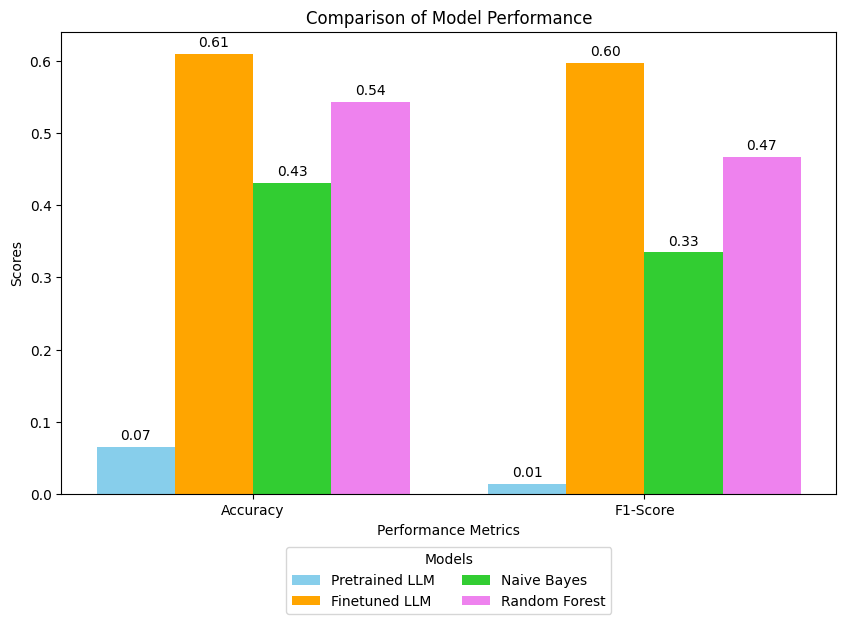

In [114]:
### PLOT THE MODELS PERFORMANCE METRICS - this is just an example for now - REPLACE TEST_ACCS and F1

# Data: Replace these values with your actual metrics
models = ['Pretrained LLM', 'Finetuned LLM', 'Naive Bayes', 'Random Forest']

# Define categories and colors
categories = ['Accuracy', 'F1-Score']
metrics = [test_accs, test_f1s]  # Group metrics by category
colors = ['skyblue', 'orange', 'limegreen', 'violet']  # Assign a color to each model


# Bar width and positions
x = np.arange(len(categories))  # X positions for categories
bar_width = 0.2                 # Width of each bar
offsets = np.linspace(-bar_width * 1.5, bar_width * 1.5, len(models))  # Offsets for subcategories

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars for each model within each category
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]  # Get metric values for the model
    plt.bar(x + offsets[i], values, width=bar_width, label=model, color=colors[i])

# Add labels, title, and legend
plt.xlabel('Performance Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(x, categories)  # Set categories as x-axis labels
plt.legend(title='Models', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # move legend below


# Add value labels on top of the bars
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]
    for j, value in enumerate(values):
        plt.text(x[j] + offsets[i], value + 0.01, f'{value:.2f}', ha='center')

# Show the plot
#plt.tight_layout()
plt.show()


### **3.2 - Examining the BERT model's Attention Matrix**

**Attention Analysis & Visualization Functions**

In [67]:
### REMEMBER TO PICK THE NUMBER OF EXAMPLES IN 3.1 - eg 3 for pos, neg examples


# Attentions Analysis
def analyze_attention(model, example_data, layer_index=11, head_index=0):
  '''This function does the actual attention analysis'''

  # Extract data from the example
  input_ids = example_data['input_ids']
  attentions = example_data['attentions']
  attention_mask = example_data['attention_mask'] #to filter out
  label = example_data['label'].item()
  prediction = example_data['prediction'].item()

  # Convert input IDs to tokens
  tokens = model.tokenizer.convert_ids_to_tokens(input_ids.numpy())


  # Filter out [PAD] tokens
  #valid_tokens = [token for token in tokens if token != '[PAD]']          # Filter out PAD token indicating truncated input.
  valid_tokens = []
  valid_indices = []
  for i, token in enumerate(tokens):
    if token != '[PAD]':
      valid_tokens.append(token)
      valid_indices.append(i)


  # Get attention matrix for the specified layer and head
  attention_matrix = attentions[layer_index][head_index]  # Shape: [seq_len, seq_len] / attentions[layer_index] shape: [num_heads, seq_len, seq_len]
  filtered_attention_matrix = attention_matrix[np.ix_(valid_indices, valid_indices)]

  # Get attention from [CLS] token to all other tokens
  cls_attention = filtered_attention_matrix[0, :].numpy()

  return filtered_attention_matrix, valid_tokens, cls_attention, label, prediction



## Plotting Functions:


def attention_bar_chart(attention_matrix, tokens, cls_attention, label, prediction, layer, head):
  plt.figure(figsize=(10, 5))
  sns.barplot(x=tokens, y=cls_attention)
  plt.xticks(rotation=90)
  #plt.title(f'Attention from [CLS] Token\nTrue Label: {label}, Prediction: {prediction}')
  plt.title(f'Attention from [CLS] Token - Layer: {layer}, Head: {head}\nTrue Label: {label_mapping[label]}, Prediction: {label_mapping[prediction]}')
  plt.xlabel('Tokens')
  plt.ylabel('Attention Weight')
  plt.show()


def attention_heatmap(attention_matrix, tokens, label, prediction, layer, head):
  plt.figure(figsize=(8, 6))
  sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
  plt.title(f"Attention Heatmap - Layer: {layer}, Head: {head}\nTrue Label: {label_mapping[label]}, Prediction: {label_mapping[prediction]}")
  plt.xlabel("Tokens")
  plt.ylabel("Tokens")
  plt.show()


def attention_headview(attention_matrix, tokens):
  '''Visualizes attention using BertViz tools'''
  head_view(attention_matrix, tokens)



#### **Pretrained LLM Attention Analysis**

**Attention Bar Chart**

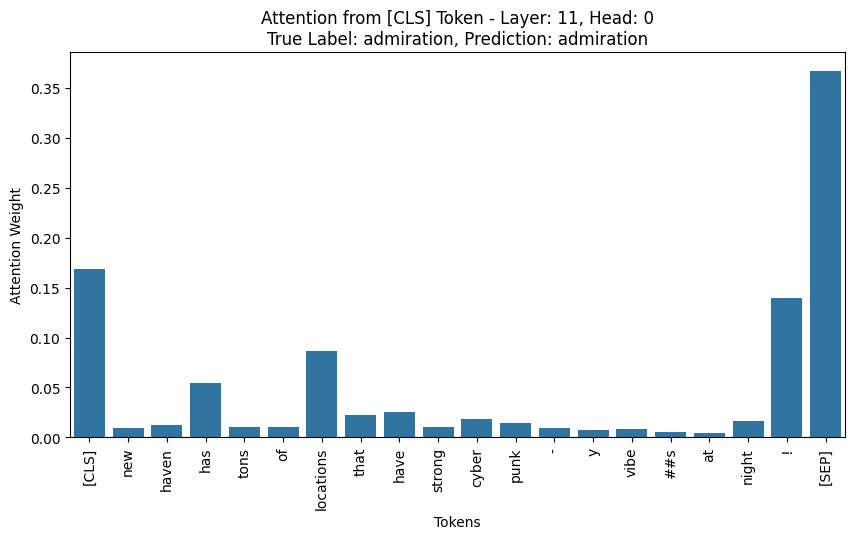

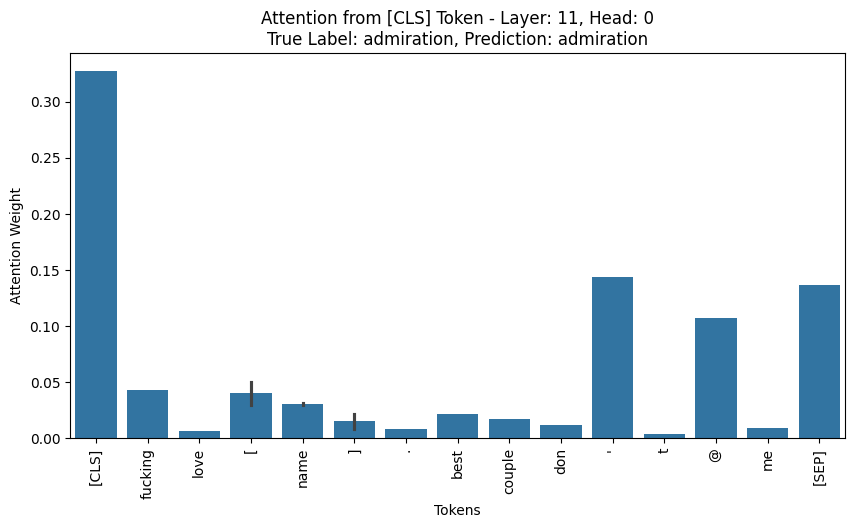

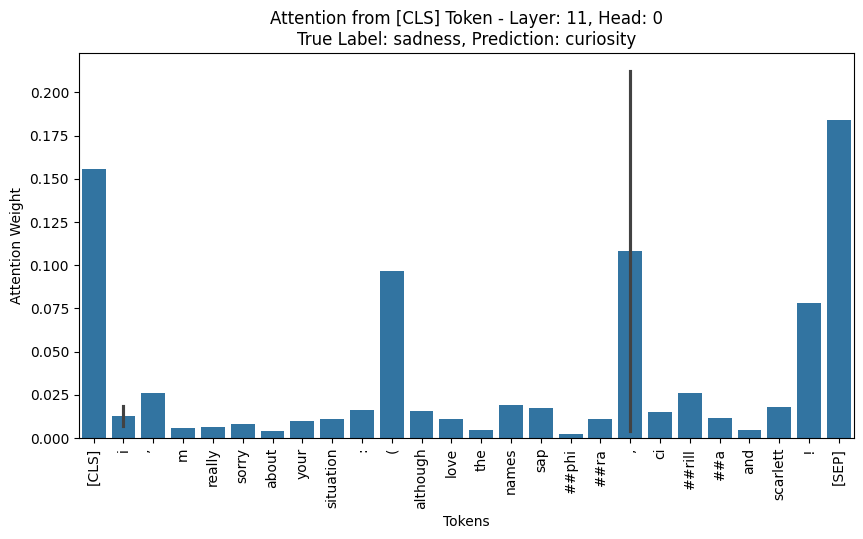

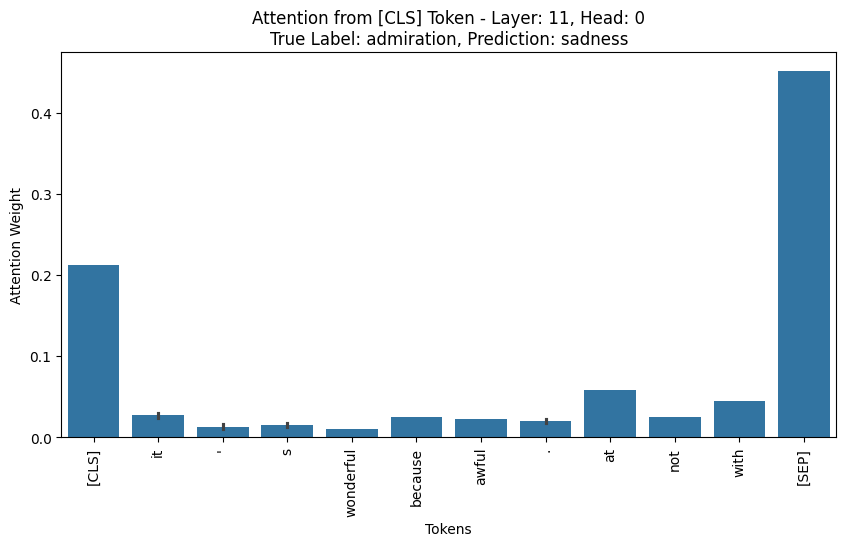

In [69]:
# Plot correct examples:
for correct_eg in correct_pretrained:
  attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(model_pretrained, correct_eg, layer_index=11, head_index=0)
  attention_bar_chart(attention_matrix, tokens, cls_attention, label, prediction, 11, 0)

# Plot incorrect examples:
for incorrect_eg in incorrect_pretrained:
  attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(model_pretrained, incorrect_eg, layer_index=11, head_index=0)
  attention_bar_chart(attention_matrix, tokens, cls_attention, label, prediction, 11, 0)


**Attention Matrix Heatmap**

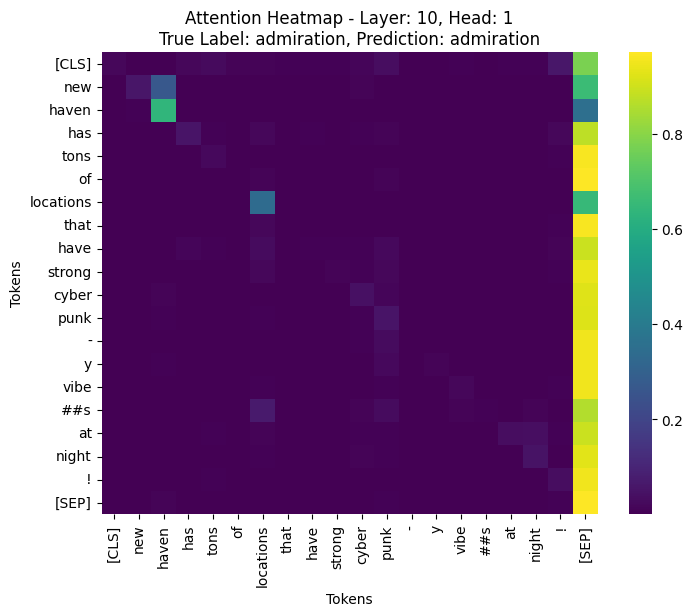

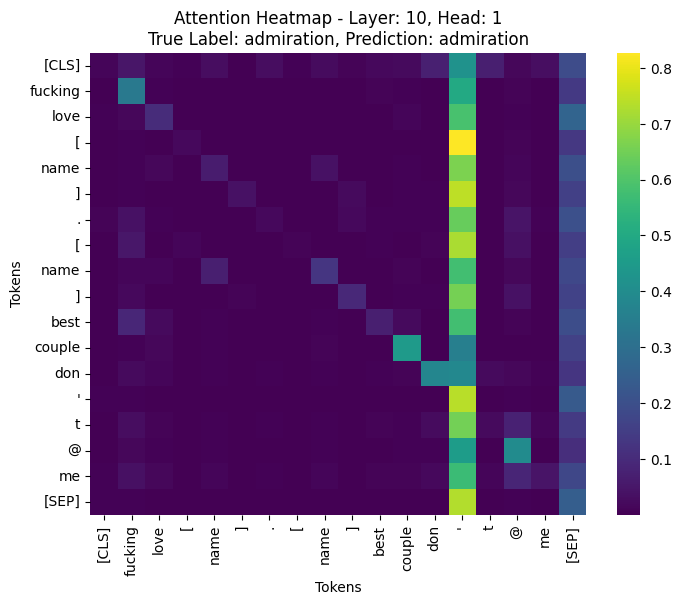

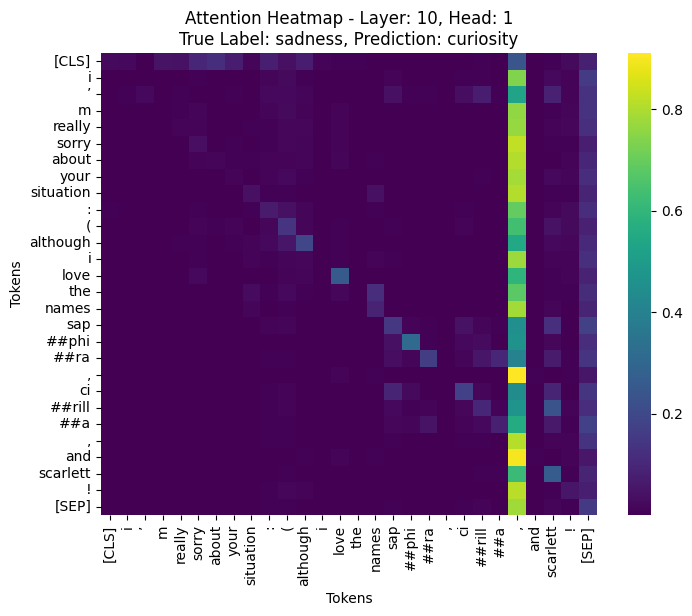

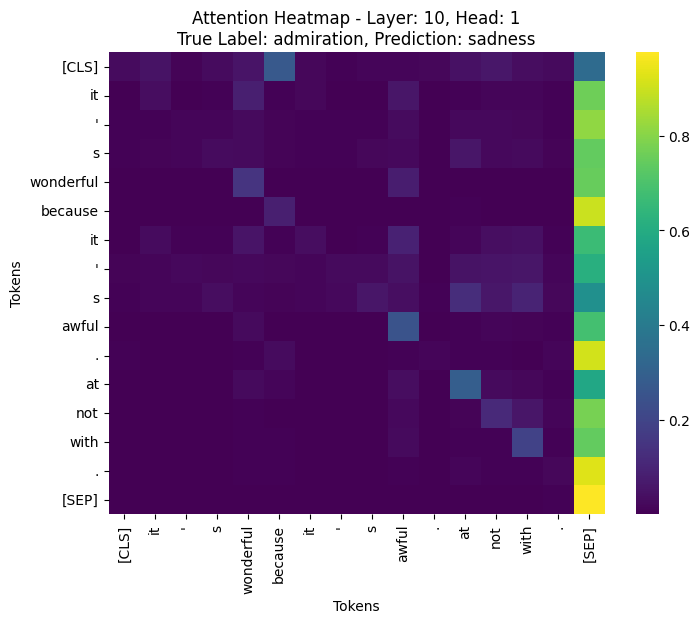

In [70]:

# Plot correct examples:
for correct_eg in correct_pretrained:
  attention_matrix, tokens, _, label, prediction = analyze_attention(model_pretrained, correct_eg, layer_index=10, head_index=1)
  attention_heatmap(attention_matrix, tokens, label, prediction, layer=10, head=1)


# Plot incorrect examples:
for incorrect_eg in incorrect_pretrained:
  attention_matrix, tokens, _, label, prediction = analyze_attention(model_pretrained, incorrect_eg, layer_index=10, head_index=1)
  attention_heatmap(attention_matrix, tokens, label, prediction, 10, 1)


**Bertviz Headview**

In [73]:
example_data = correct_pretrained[0]
input_ids = example_data['input_ids']
tokens = model_pretrained.tokenizer.convert_ids_to_tokens(input_ids.numpy())
print(tokens)
head_view(model_pretrained.attentions, tokens)

In [74]:
#example_data = correct_pretrained[0]

# Extract data from the example
input_ids = example_data['input_ids']
attentions = example_data['attentions']
attention_mask = example_data['attention_mask'] #to filter out
label = example_data['label'].item()
prediction = example_data['prediction'].item()

# Convert input IDs to tokens
tokens = model_pretrained.tokenizer.convert_ids_to_tokens(input_ids.numpy())




# Get attention matrix for the specified layer and head
attention_matrix = attentions[11][0]  # Shape: [seq_len, seq_len] / attentions[layer_index] shape: [num_heads, seq_len, seq_len]
#filtered_attention_matrix = attention_matrix[np.ix_(valid_indices, valid_indices)]

# Get attention from [CLS] token to all other tokens
#cls_attention = filtered_attention_matrix[0, :].numpy()
print(attention_matrix.shape)
print(len(model_pretrained.attentions[9]))


#attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(model_pretrained, example_data, layer_index=11, head_index=0)
#input_ids = example_data['input_ids']
#tokens = model_pretrained.tokenizer.convert_ids_to_tokens(input_ids.numpy())
attention_headview(attention_matrix, tokens)


#### **Finetuned LLM Attention Analysis**

**Attention Bar Chart**

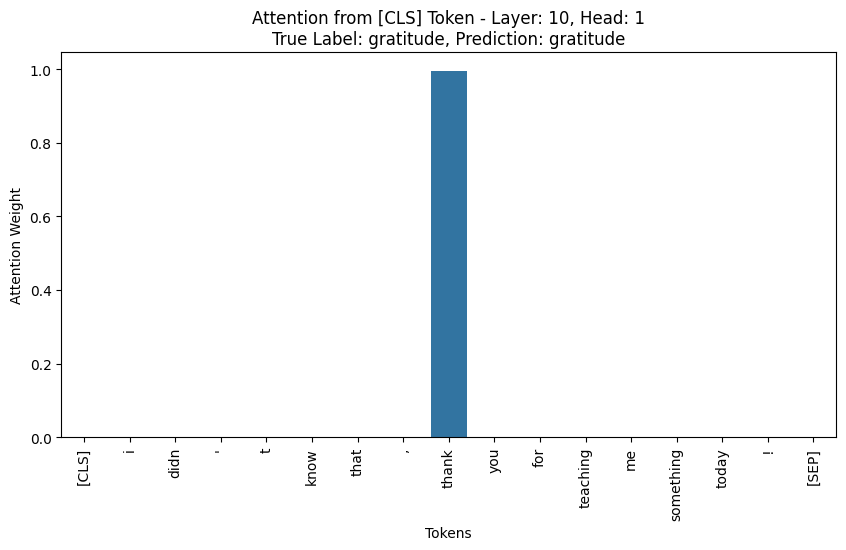

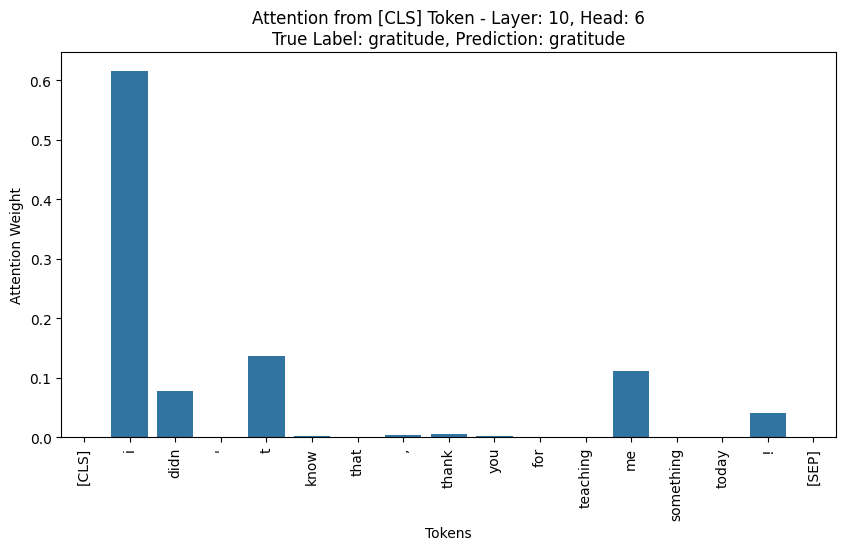

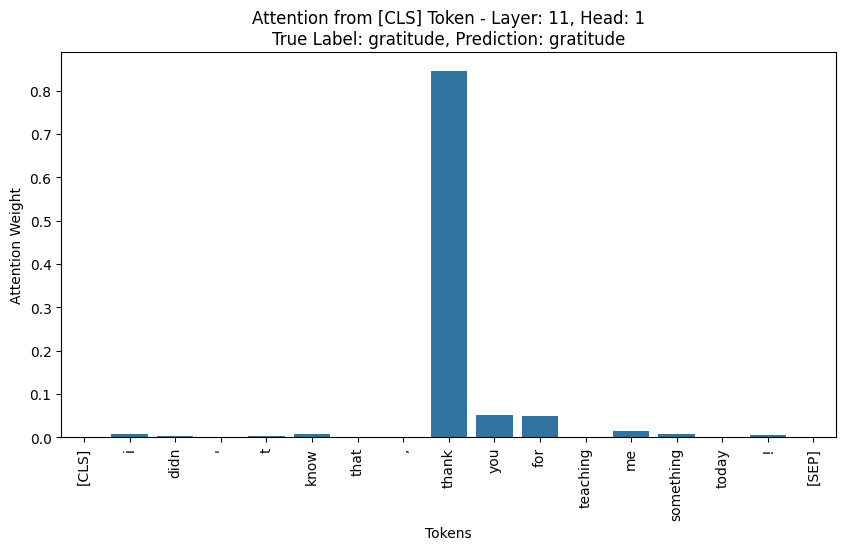

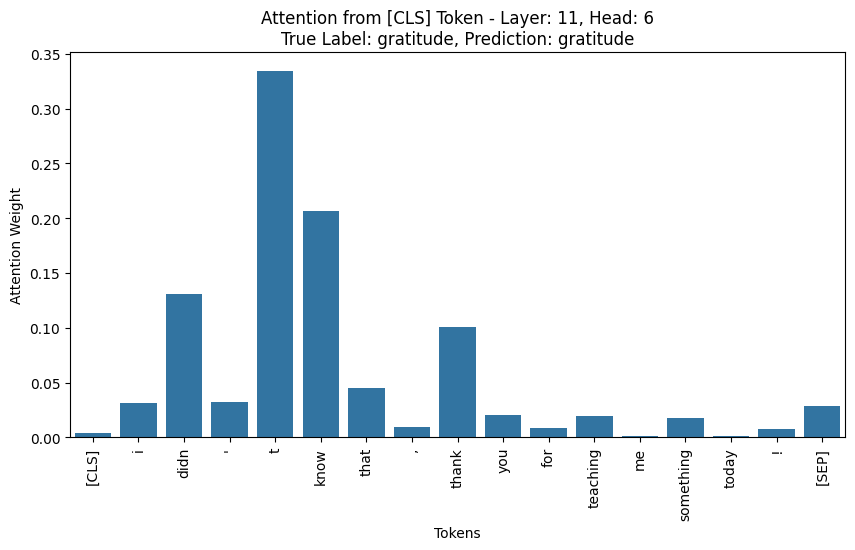

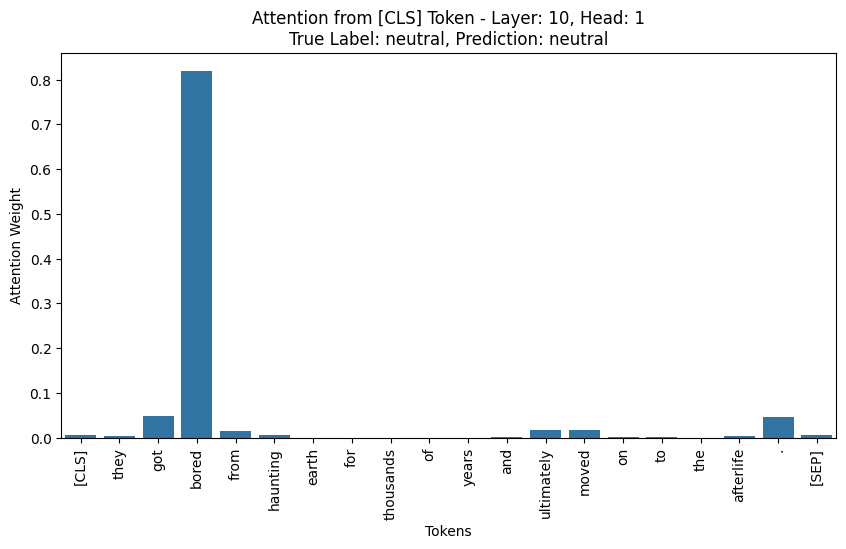

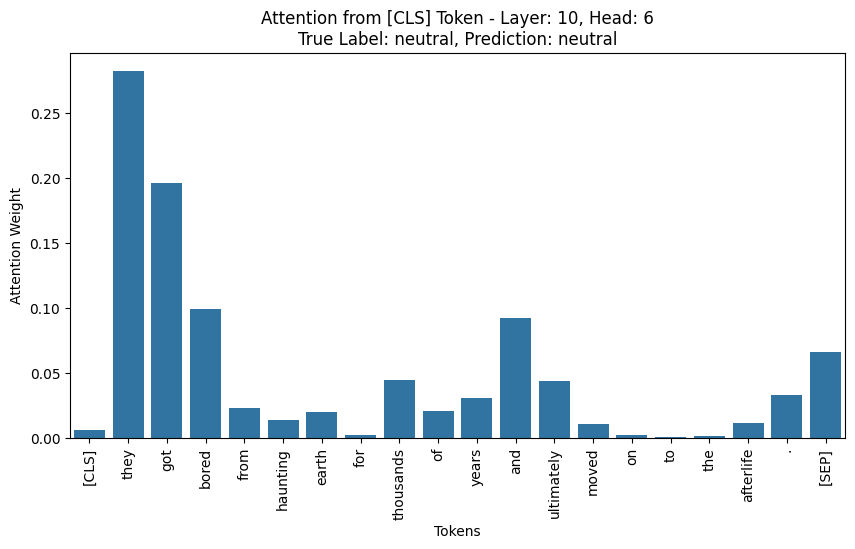

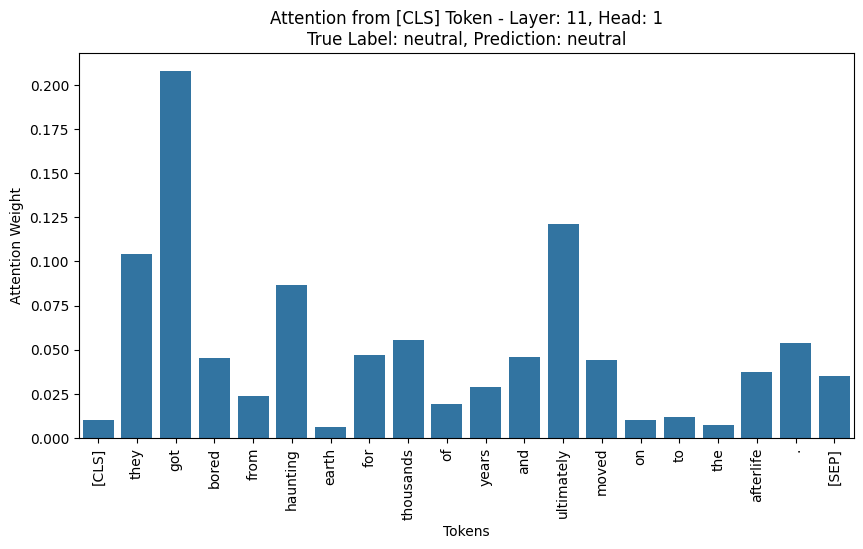

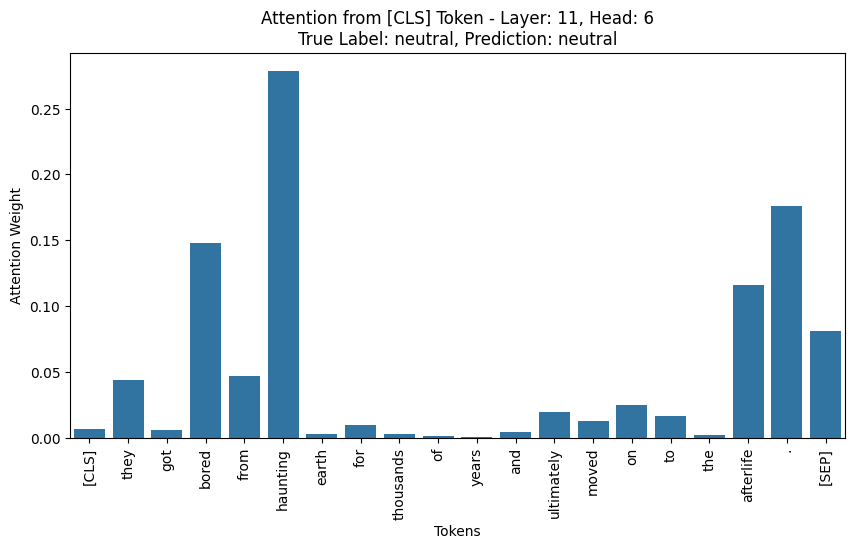

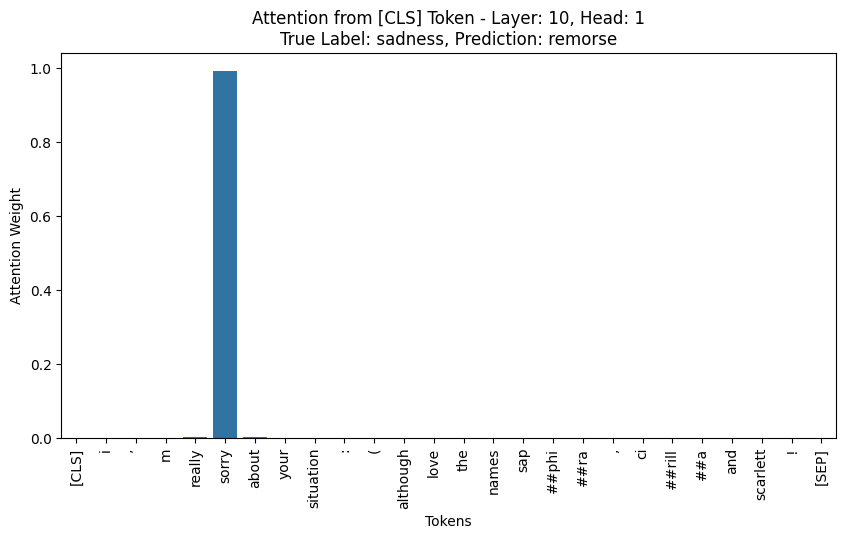

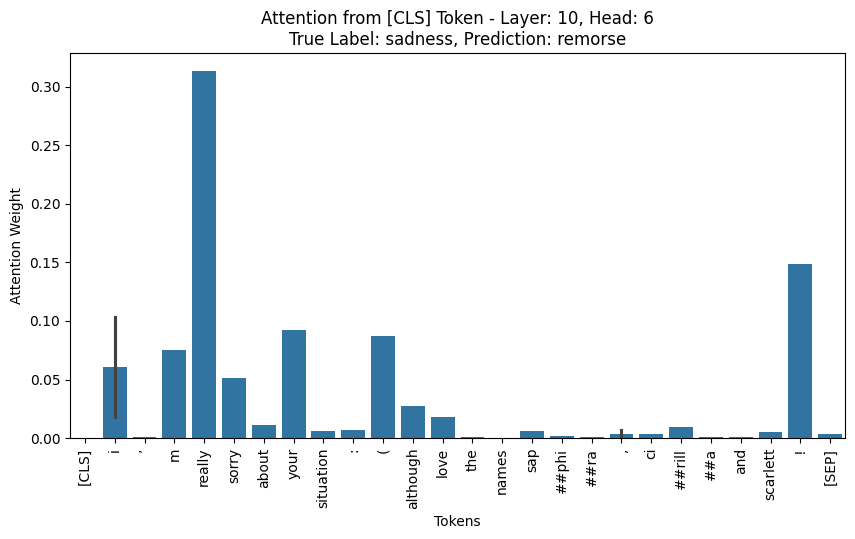

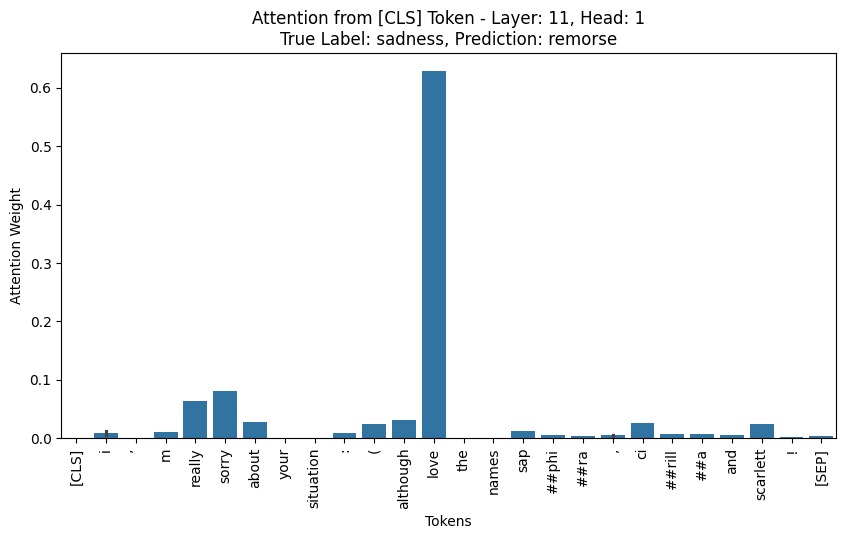

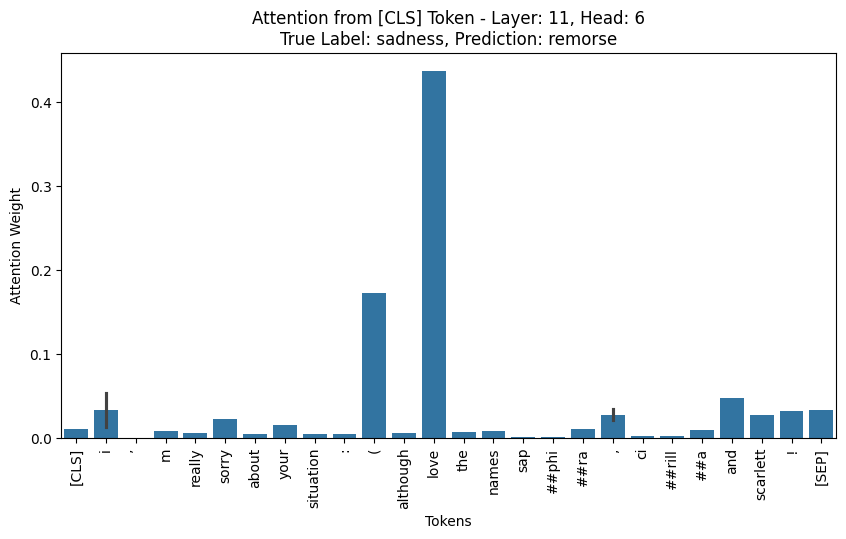

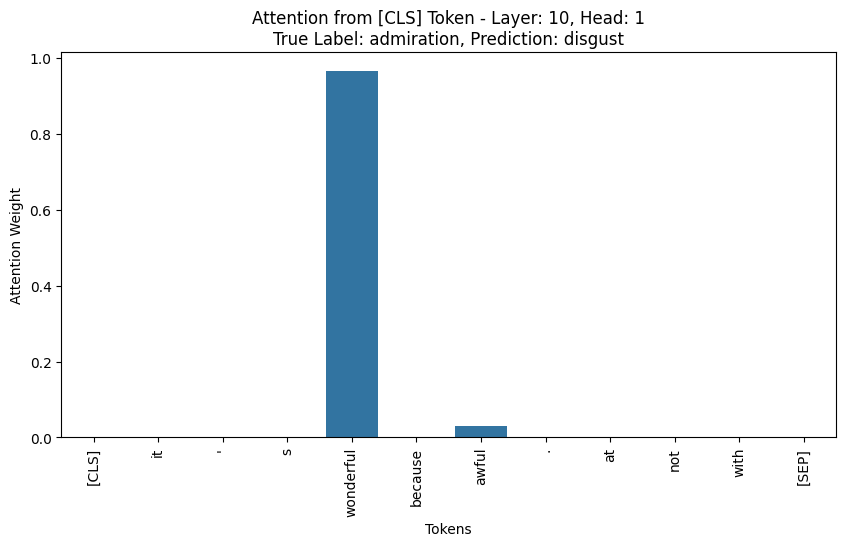

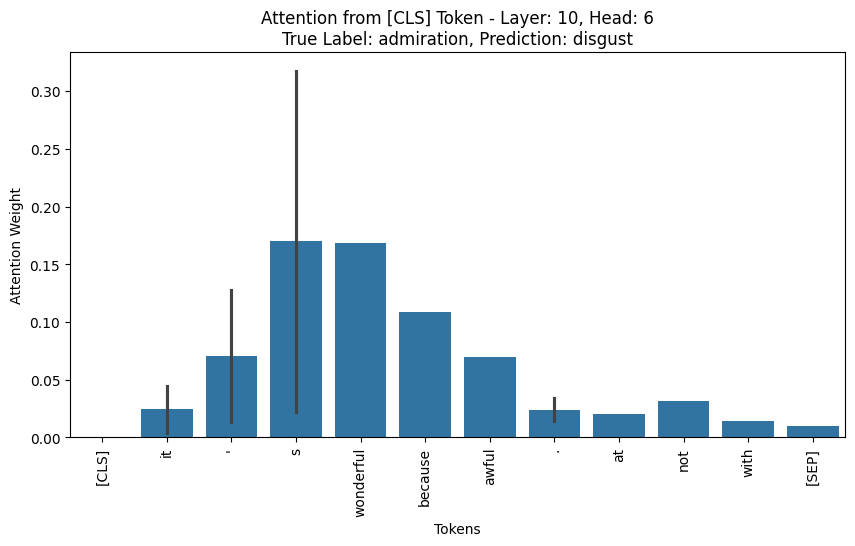

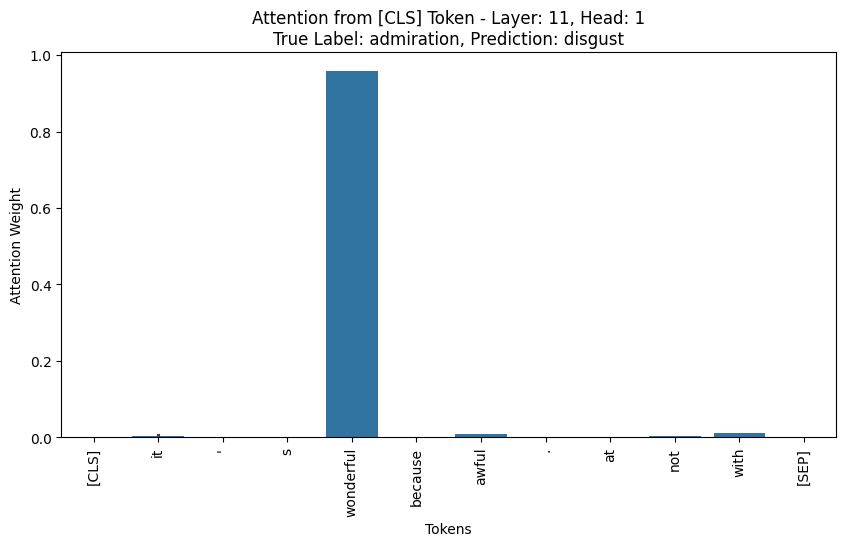

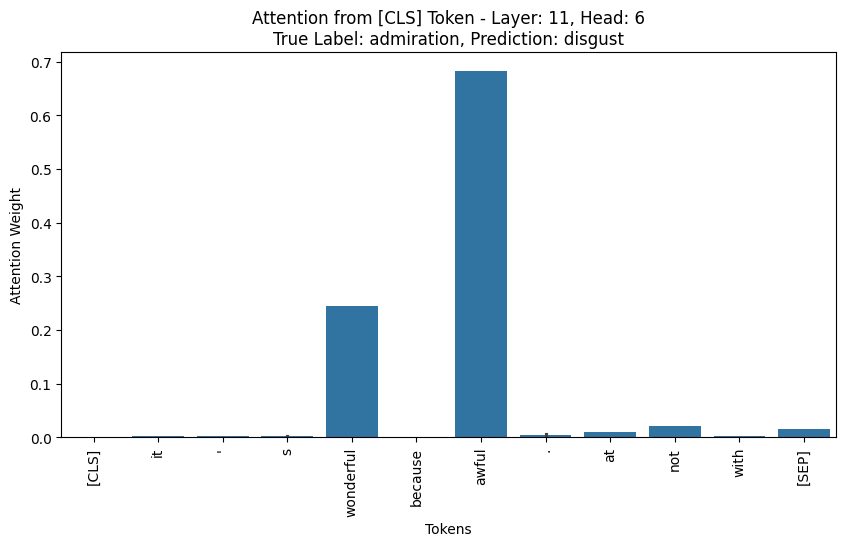

In [71]:
layers = [10, 11]
heads = [1, 6]

# Plot correct examples:
for correct_eg in correct_finetuned:
  for layer in layers:
    for head in heads:
      attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(finetuned_model, correct_eg, layer_index=layer, head_index=head)
      attention_bar_chart(attention_matrix, tokens, cls_attention, label, prediction, layer, head)

# Plot incorrect examples:
for incorrect_eg in incorrect_finetuned:
  for layer in layers:
    for head in heads:
      attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(finetuned_model, incorrect_eg, layer_index=layer, head_index=head)
      attention_bar_chart(attention_matrix, tokens, cls_attention, label, prediction, layer, head)


**Attention Heatmap**

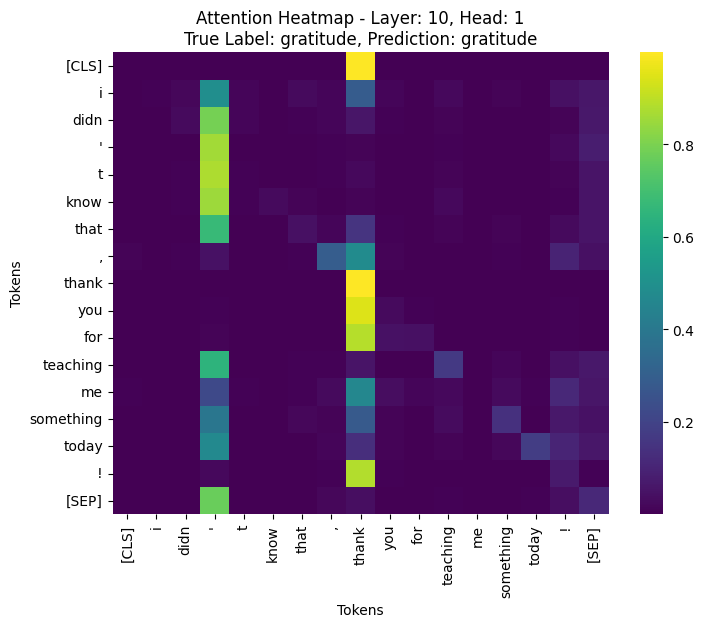

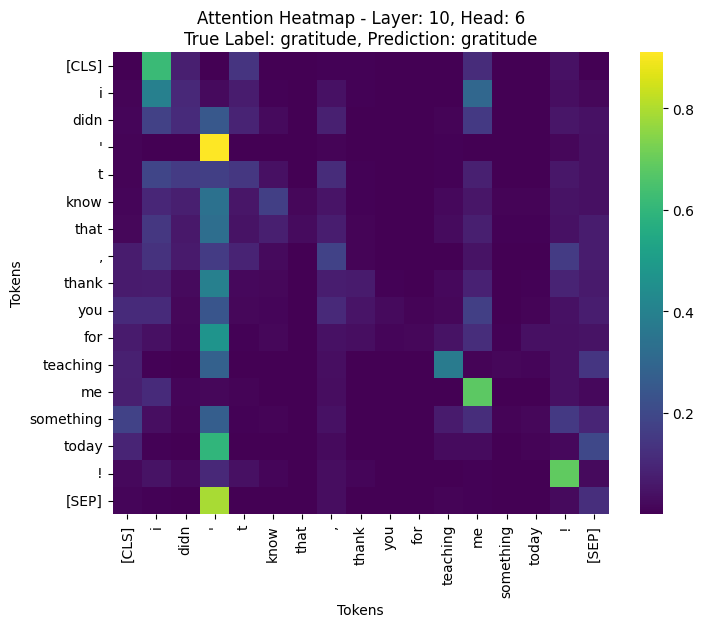

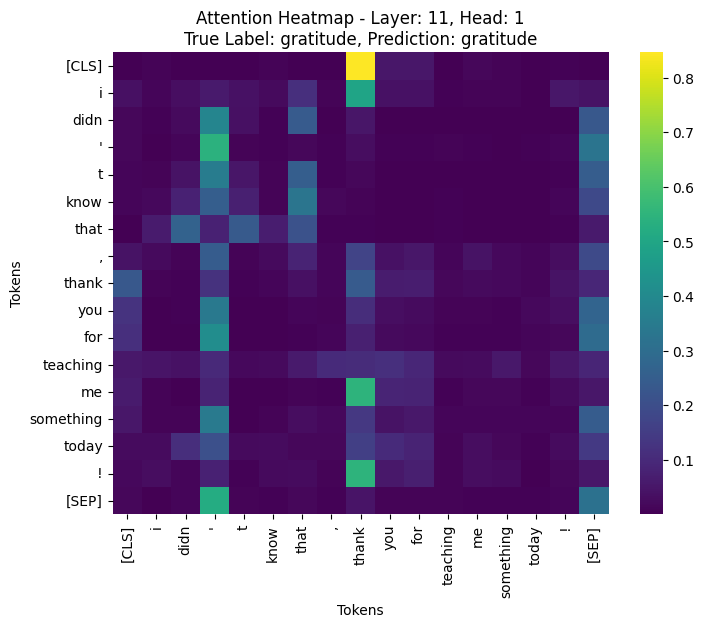

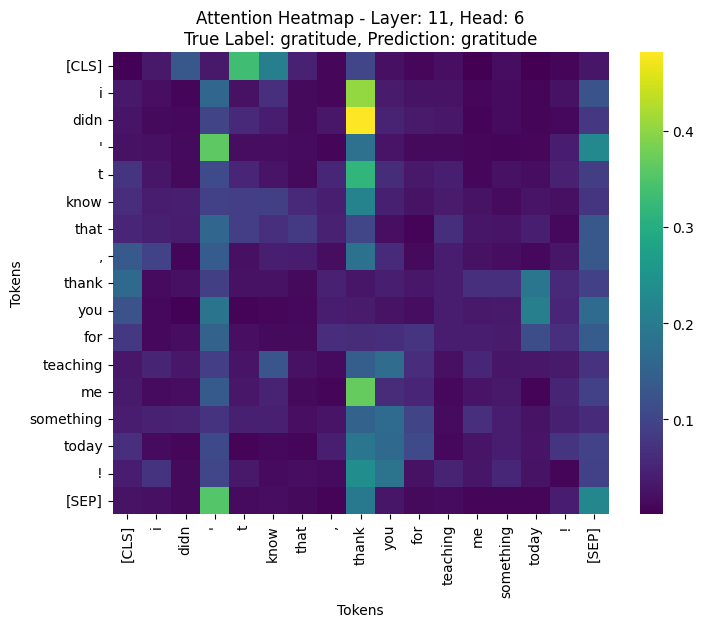

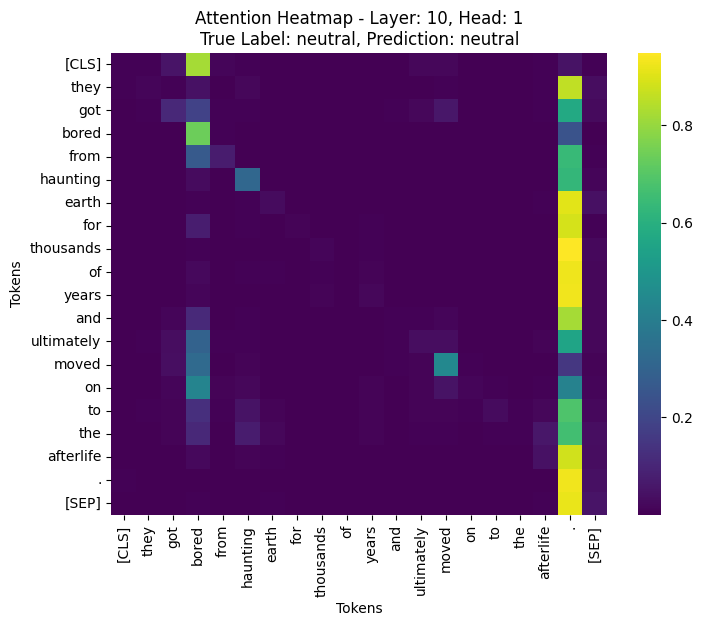

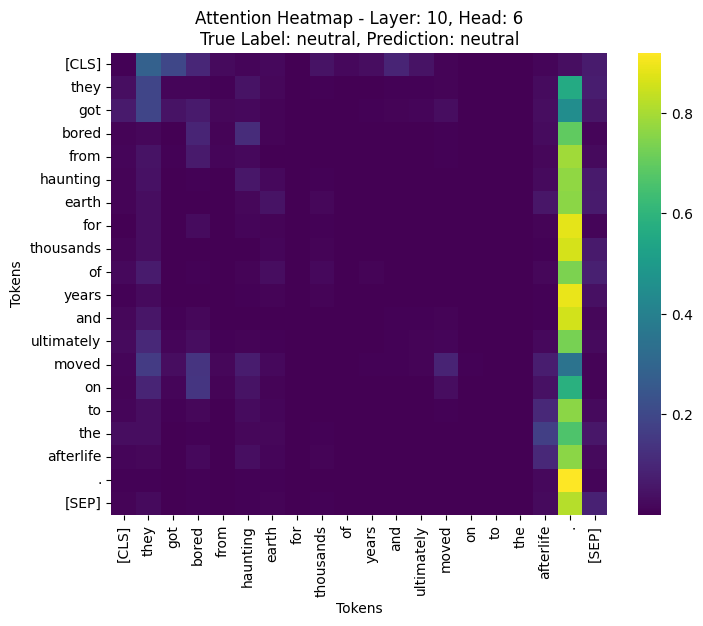

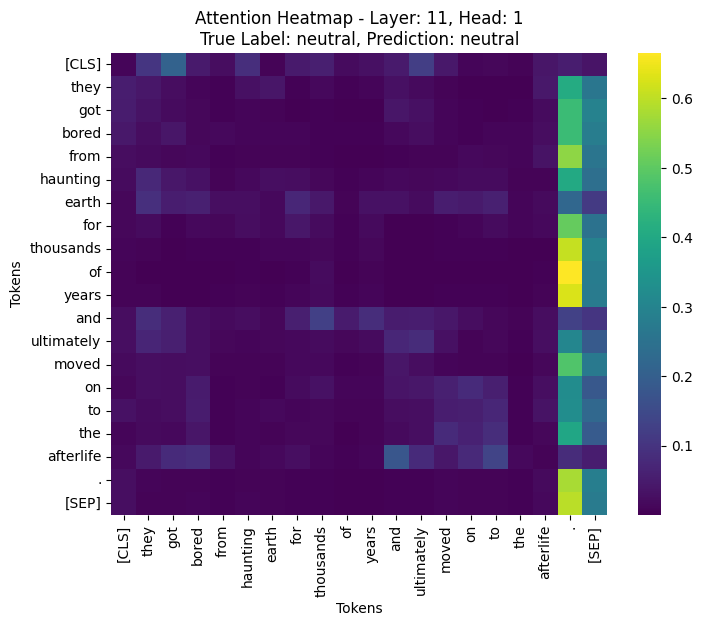

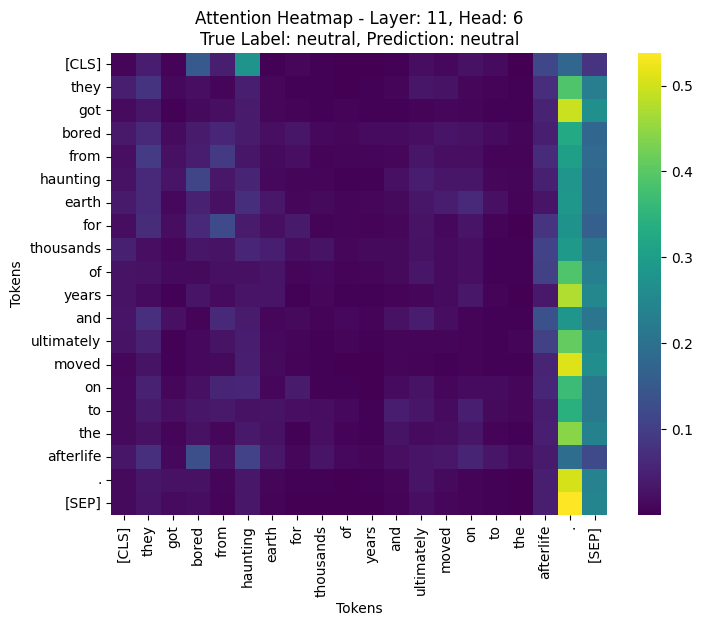

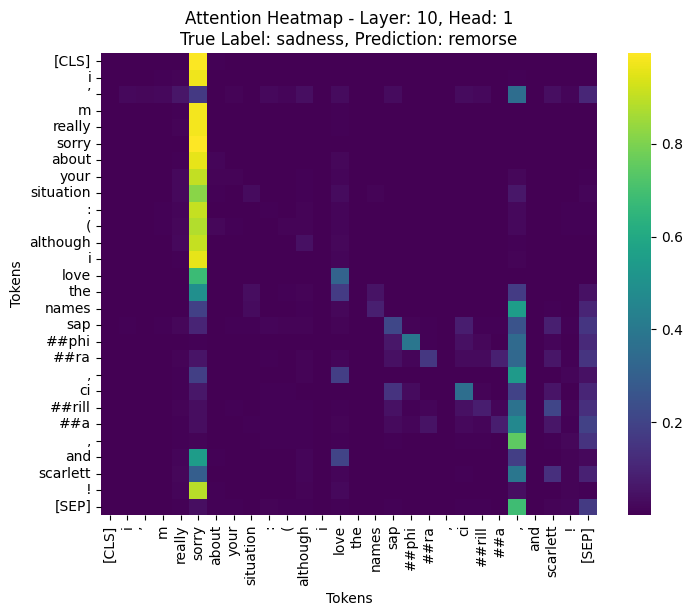

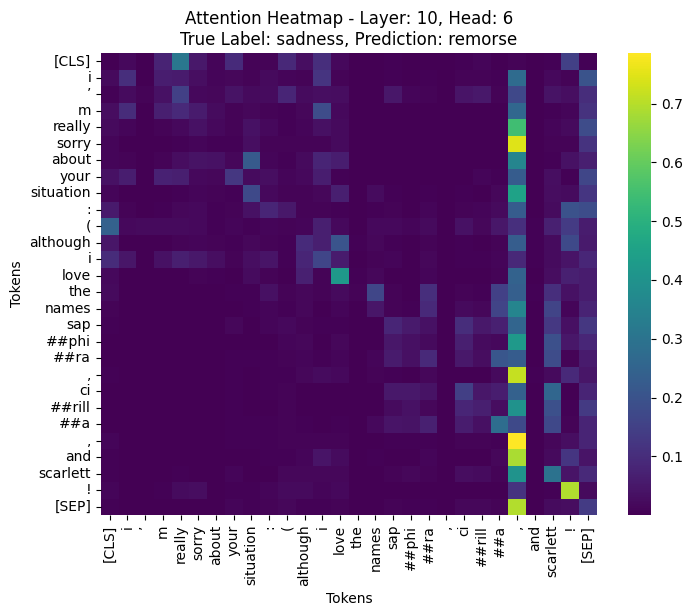

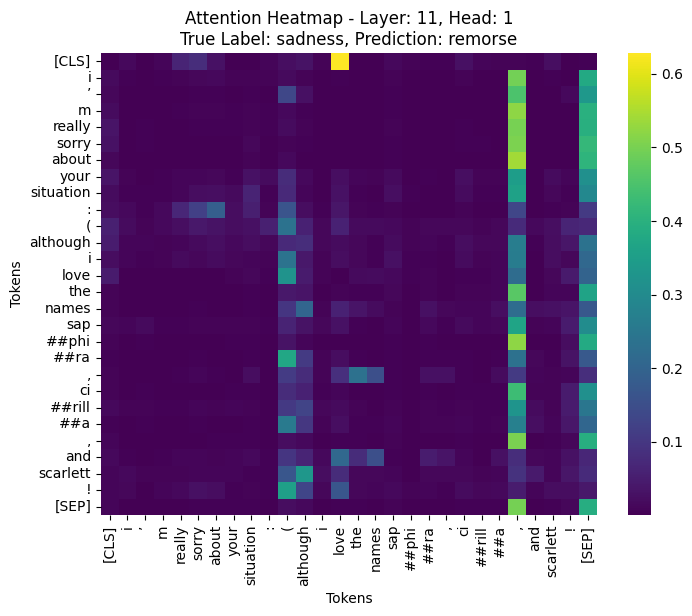

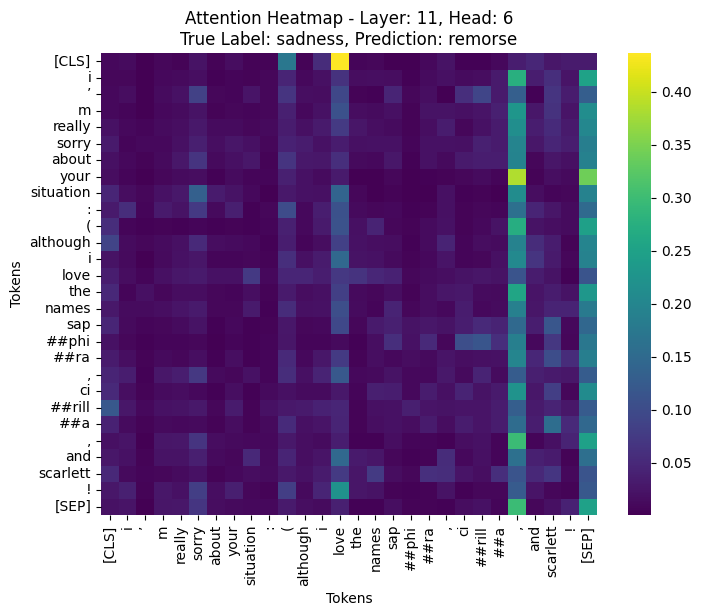

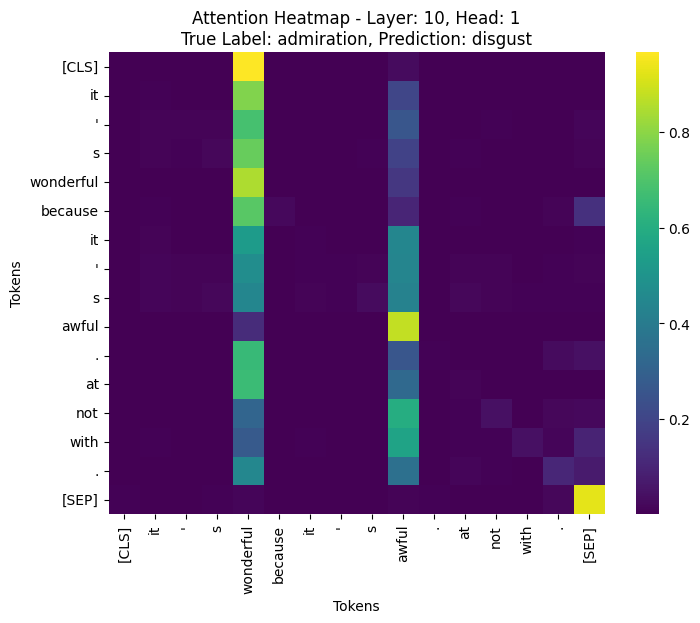

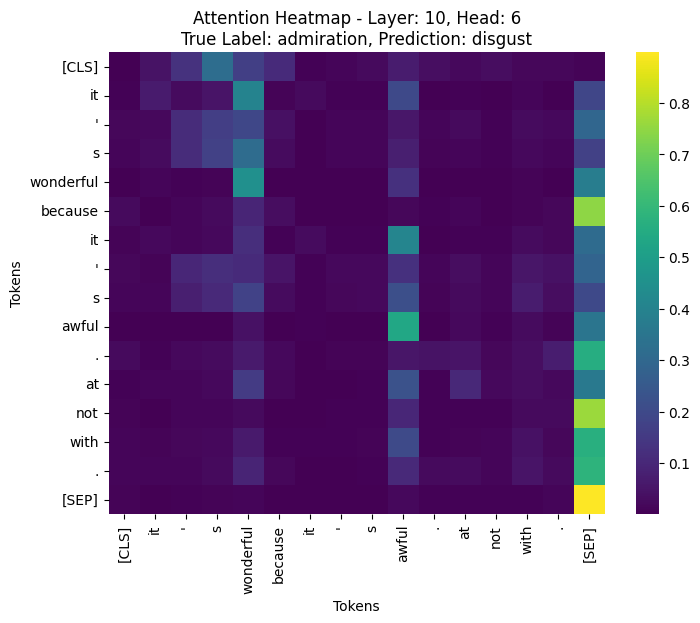

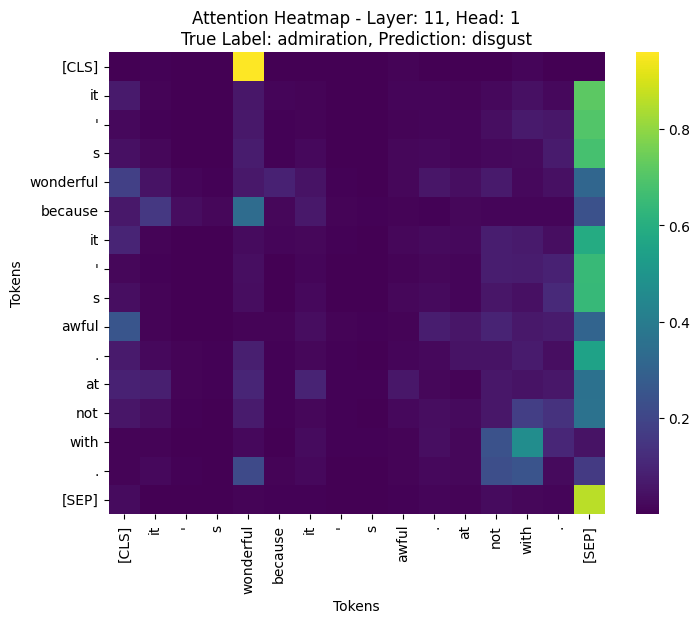

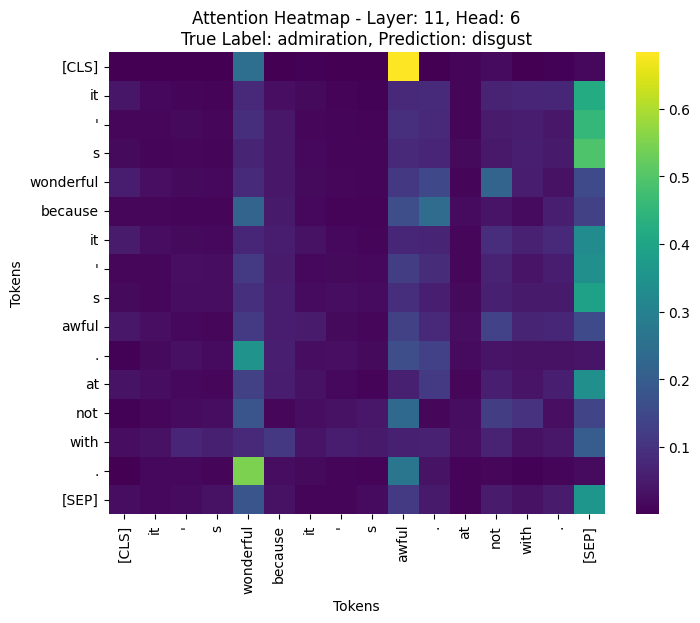

In [72]:
layers = [10, 11]
heads = [1, 6]

# Plot correct examples:
for correct_eg in correct_finetuned:
  for layer in layers:
    for head in heads:
      attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(finetuned_model, correct_eg, layer_index=layer, head_index=head)
      attention_heatmap(attention_matrix, tokens, label, prediction, layer, head)

# Plot incorrect examples:
for incorrect_eg in incorrect_finetuned:
  for layer in layers:
    for head in heads:
      attention_matrix, tokens, cls_attention, label, prediction = analyze_attention(finetuned_model, incorrect_eg, layer_index=layer, head_index=head)
      attention_heatmap(attention_matrix, tokens, label, prediction, layer, head)


### **3.3 - Additional Experiments**
In this subsection, we will run additional experiments on our models to enhance their performance given this task and dataset, but ultimately we hope to better familiarize ourselves with these models. We will conclude this section by taking the best enhancements of the models and then use the test set again to compare each model's performance once more, and to their baseline versions seen in 3.1. The subsection will include the following:

  * DistilGPT2 Implementation (LLM Comparison)
  * LLM with class-weighting loss function & sample-weighting inputs
  * XGBoost Implementation
  * Feature Selection with Random Forest
  * Pre-implemented vs. Custom Naive Bayes (NB)
  * NB - Vocabulary Size vs. Laplace Smoothing


#### **DistilGPT2 Implementation**

**Preprocessing for DistilGPT2**

In [75]:
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer

PATH_TO_LLM_2 = "distilgpt2"

# Load GPT2 tokenizer
TOKENIZER_LLM_2 = GPT2Tokenizer.from_pretrained(PATH_TO_LLM_2)

# GPT-2 does not have padding tokens by default; add one
TOKENIZER_LLM_2.pad_token = TOKENIZER_LLM_2.eos_token

# Tokenize datasets (train, validation, and test)
x_train_GPT = TOKENIZER_LLM_2(clean_train_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_GPT = torch.tensor(clean_train_df['labels'].values)

x_validation_GPT = TOKENIZER_LLM_2(clean_validation_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
y_validation_GPT = torch.tensor(clean_validation_df['labels'].values)

x_test_GPT = TOKENIZER_LLM_2(clean_test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_GPT = torch.tensor(clean_test_df['labels'].values)

# Combine input_ids, attention_masks, and labels into TensorDataset
train_dataset_GPT = TensorDataset(x_train_GPT['input_ids'], x_train_GPT['attention_mask'], y_train_GPT)
validation_dataset_GPT = TensorDataset(x_validation_GPT['input_ids'], x_validation_GPT['attention_mask'], y_validation_GPT)
test_dataset_GPT = TensorDataset(x_test_GPT['input_ids'], x_test_GPT['attention_mask'], y_test_GPT)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

**Model Definitions**

In [76]:
class PretrainedGPT2():
  '''Pretrained DistilGPT2 model with no finetuning, adapted to classification tasks.'''

  def __init__(self, tokenizer, verbose=False, output_attentions=False):
    self.verbose = verbose
    self.tokenizer = tokenizer
    self.output_attentions = output_attentions
    self.attentions = None

    # Load DistilGPT2 with a classification head
    self.model = AutoModelForSequenceClassification.from_pretrained("distilgpt2", num_labels=NUM_LABELS,output_attentions=self.output_attentions)
    self.model.config.pad_token_id = self.tokenizer.eos_token_id

    # GPU handling
    self.device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
    self.model.to(self.device)
    if self.verbose:
      print("Device:", self.device)


  def predict(self, data_loader, num_examples=0):
    # Switch to eval mode
    self.model.eval()

    y_preds = []
    y_true = []

    # Collect data for attention analysis if needed
    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
      for batch in data_loader:
        input_ids = batch[0].to(self.device)
        attention_mask = batch[1].to(self.device)
        labels = batch[2].to(self.device)

        # Forward pass
        outputs = self.model(input_ids, attention_mask=attention_mask,
                              labels=labels, output_attentions=self.output_attentions)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        y_preds.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        attentions = outputs.attentions  # tuple of attention matrices

        if self.output_attentions and num_examples > 0:
          self.attentions = attentions

          # Collect examples for attention analysis
          for i in range(len(labels)):
            is_correct = (predictions[i] == labels[i])
            example_data = {
                'input_ids': input_ids[i].cpu(),
                'attention_mask': attention_mask[i].cpu(),
                'label': labels[i].cpu(),
                'prediction': predictions[i].cpu(),
                'attentions': [layer[i].cpu() for layer in attentions]}

            if is_correct and len(correct_examples) < num_examples:
              correct_examples.append(example_data)
            elif not is_correct and len(incorrect_examples) < num_examples:
              incorrect_examples.append(example_data)

            if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
              break

    return y_true, y_preds, correct_examples, incorrect_examples


In [82]:
class FinetunedGPT2(PretrainedGPT2):

  def __init__(self, tokenizer, lr, epochs, verbose=False, output_attentions=False, trainable_layers=[5]):
    super().__init__(tokenizer, verbose, output_attentions)
    self.model.to(self.device)

    # Freeze all layers in the model
    for param in self.model.parameters():
      param.requires_grad = False

    # Unfreeze the specified layers (last 2 layers 4 and 5)
    for layer_idx in trainable_layers:
      for param in self.model.transformer.h[layer_idx].parameters():
        param.requires_grad = True

    # Always unfreeze the classification head
    for param in self.model.score.parameters():
      param.requires_grad = True

    self.loss_fn = nn.CrossEntropyLoss()
    self.scheduler = None  # will define after total steps

    self.learning_rate = lr
    self.num_epochs = epochs
    self.optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.learning_rate) # AdamWarmup, but skip over all frozen layers

  def train_LLM(self, train_loader):
    total_iterations = len(train_loader) * self.num_epochs
    self.scheduler = get_linear_schedule_with_warmup(
        self.optimizer,
        num_warmup_steps=0,
        num_training_steps=total_iterations
    )

    self.model.train()
    for epoch in range(self.num_epochs):
      total_loss = 0
      for batch in train_loader:
        self.model.zero_grad()
        input_ids = batch[0].to(self.device)
        attention_mask = batch[1].to(self.device)
        labels = batch[2].to(self.device)

        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()

      avg_train_loss = total_loss / len(train_loader)
      if self.verbose:
        print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {avg_train_loss:.4f}")


**Example Usage:**

In [78]:
test_accs2 = test_accs[:2]
test_f1s2 = test_f1s[:2]

# Check
print(test_accs2)
print(test_f1s2)

[0.0656, 0.6098]
[0.0141, 0.5976]


In [79]:
# Model
pretrained_GPT2 = PretrainedGPT2(TOKENIZER_LLM_2, verbose=True)

# Load Data - CHANGE TO TEST SET
test_loader = DataLoader(test_dataset_GPT, batch_size=64, shuffle=False)

y, y_preds, *_ = pretrained_GPT2.predict(test_loader)
acc, f1 = compute_acc_and_f1(y, y_preds)

# Store Results
test_accs2.append(acc)
test_f1s2.append(f1)

print("Pretrained DistilGPT2 without finetuning:")
print(f"\tTest Accuracy Score: {acc:.4f}")
print(f"\tTest F1 Score: {f1:.4f}\n")

print(classification_report(y, y_preds, target_names=label_names))


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Pretrained DistilGPT2 without finetuning:
	Test Accuracy Score: 0.0426
	Test F1 Score: 0.0068

                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00       342
     amusement       0.00      0.00      0.00       179
         anger       0.00      0.00      0.00       130
     annoyance       0.04      0.95      0.08       192
      approval       0.00      0.00      0.00       230
        caring       0.14      0.02      0.04        86
     confusion       0.00      0.00      0.00        96
     curiosity       0.00      0.00      0.00       176
        desire       0.00      0.00      0.00        55
disappointment       0.00      0.00      0.00        88
   disapproval       0.15      0.03      0.04       195
       disgust       0.00      0.00      0.00        75
 embarrassment       0.00      0.00      0.00        23
    excitement       0.00      0.00      0.00        55
          fear       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
finetuned_GPT2 = FinetunedGPT2(TOKENIZER_LLM_2, verbose=True, lr=2e-5, epochs=3)

# Prep DataLoaders
train_loader1 = DataLoader(train_dataset_GPT, batch_size=32, shuffle=True)
test_loader1 = DataLoader(test_dataset_GPT, batch_size=64, shuffle=False)

# Train Model:
start_time = time.time()
finetuned_GPT2.train_LLM(train_loader1)
elapsed_time = time.time() - start_time

# Predict:
y_train, yh_train, *_ = finetuned_GPT2.predict(train_loader1)
y_test, yh_test, *_ = finetuned_GPT2.predict(test_loader1)

# Eval
train_acc, train_f1 = compute_acc_and_f1(y_train, yh_train)
test_acc, test_f1 = compute_acc_and_f1(y_test, yh_test)

# Store Results:
test_accs2.append(test_acc)
test_f1s2.append(test_f1)


# Print Results:
print(f"\nFinetuned DistilGPT2 Performance:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\tTest Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tTraining Time: {elapsed_time:.2f}s")

enhanced_classification_report(y_test, yh_test)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device: cuda
Epoch 1/3, Training Loss: 2.7979
Epoch 2/3, Training Loss: 2.2017
Epoch 3/3, Training Loss: 2.0506

Finetuned DistilGPT2 Performance:
	Train Accuracy: 0.4747, Train F1 Score: 0.3779
	Test Accuracy: 0.4757, Test F1 Score: 0.3747
	Training Time: 2570.22s

             class  precision  recall  f1-score    support  accuracy
0       admiration     0.4526  0.6140    0.5211   342.0000    0.6140
1        amusement     0.5062  0.4581    0.4809   179.0000    0.4581
2            anger     0.1765  0.0231    0.0408   130.0000    0.0231
3        annoyance     0.2535  0.0938    0.1369   192.0000    0.0938
4         approval     0.1622  0.0261    0.0449   230.0000    0.0261
5           caring     0.0000  0.0000    0.0000    86.0000    0.0000
6        confusion     0.0000  0.0000    0.0000    96.0000    0.0000
7        curiosity     0.4412  0.1705    0.2459   176.0000    0.1705
8           desire     0.0000  0.0000    0.0000    55.0000    0.0000
9   disappointment     0.0000  0.0000    0.

**Comparison to BERT LLM**

In [102]:
print(test_accs2)
print(test_f1s2)

[0.0656, 0.6098, 0.042642509942554134]
[0.0141, 0.5976, 0.006847160227065632]


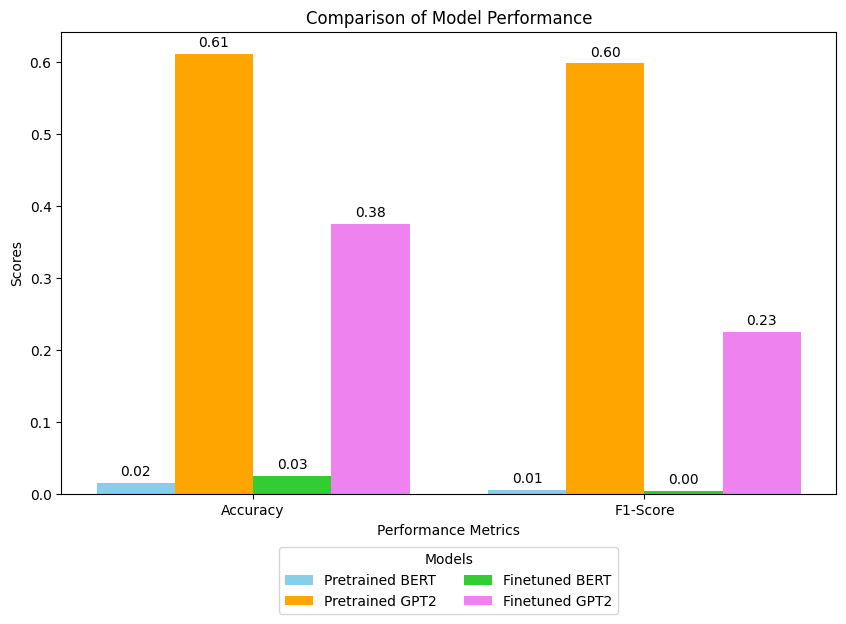

In [ ]:
### PLOT THE MODELS PERFORMANCE METRICS - this is just an example for now

# Data: Replace these values with your actual metrics
models = ['Pretrained BERT', 'Pretrained GPT2', 'Finetuned BERT', 'Finetuned GPT2']

# Define categories and colors
categories = ['Accuracy', 'F1-Score']
metrics = [test_accs2, test_f1s2]  # Group metrics by category
colors = ['skyblue', 'orange', 'limegreen', 'violet']  # Assign a color to each model


# Bar width and positions
x = np.arange(len(categories))  # X positions for categories
bar_width = 0.2                 # Width of each bar
offsets = np.linspace(-bar_width * 1.5, bar_width * 1.5, len(models))  # Offsets for subcategories

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars for each model within each category
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]  # Get metric values for the model
    plt.bar(x + offsets[i], values, width=bar_width, label=model, color=colors[i])

# Add labels, title, and legend
plt.xlabel('Performance Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(x, categories)  # Set categories as x-axis labels
plt.legend(title='Models', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # move legend below


# Add value labels on top of the bars
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]
    for j, value in enumerate(values):
        plt.text(x[j] + offsets[i], value + 0.01, f'{value:.2f}', ha='center')

# Show the plot
#plt.tight_layout()
plt.show()


#### **Class-weighting sampling & loss function**

**Calculating Class & Sample weights**

In [ ]:
label_counts = clean_train_df['labels'].value_counts()  # Class distribution
print(label_counts)
total = label_counts.sum()


# Calculate class weights (inverse frequency)
class_weights = total / label_counts.values  # Original weights
print("\nBefore Normalization:\n", torch.tensor(class_weights, dtype=torch.float))

  # Normallization
min_weight = class_weights.min()
class_weights = class_weights / min_weight  # Normalize to max weight = 1.0
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("\nAfter Normalization:\n", torch.tensor(class_weights, dtype=torch.float))
print("\n")



# Calculate sample weights
targets = clean_train_df['labels'].values  # Labels for each sample in the dataset
sample_weights = [class_weights[label] for label in targets]
sample_weights = torch.tensor(sample_weights, dtype=torch.float)  # Convert to tensor

print("Sample Weights (for sampler):\n", sample_weights)


def get_sampler_dl(dataset):
  '''Returns a DataLoader with a weighted random sampler:'''

  sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

  return DataLoader(dataset, sampler=sampler, batch_size=32)


labels
27    12719
0      2663
4      1834
15     1809
1      1615
3      1439
10     1387
18     1376
7      1363
2      1016
6       852
17      841
20      841
25      790
26      705
9       702
5       640
22      573
11      495
13      492
14      420
8       375
24      352
12      201
23       88
19       85
21       51
16       37
Name: count, dtype: int64

Before Normalization:
 tensor([  2.8116,  13.4288,  19.4989,  19.7684,  22.1430,  24.8513,  25.7830,
         25.9891,  26.2370,  35.1978,  41.9730,  42.5220,  42.5220,  45.2671,
         50.7248,  50.9416,  55.8766,  62.4101,  72.2444,  72.6850,  85.1452,
         95.3627, 101.5938, 177.9154, 406.3750, 420.7177, 701.1961, 966.5135])

After Normalization:
 tensor([  1.0000,   4.7762,   6.9351,   7.0310,   7.8755,   8.8388,   9.1702,
          9.2435,   9.3316,  12.5187,  14.9284,  15.1237,  15.1237,  16.1000,
         18.0411,  18.1182,  19.8734,  22.1972,  25.6950,  25.8516,  30.2833,
         33.9173,  36.1335,  63.2786,

<ipython-input-113-e38007a751fa>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("\nAfter Normalization:\n", torch.tensor(class_weights, dtype=torch.float))


Sample Weights (for sampler):
 tensor([343.7567, 343.7567,   6.9351,  ...,   7.0310,  16.1000,  22.1972])


**Modifying Models to take into account the new loss functions:**

In [ ]:
class FinetunedLLM_2(PretrainedLLM):

  def __init__(self, tokenizer, lr, epochs, verbose=False, output_attentions=False, trainable_layers=[10,11]):
    super().__init__(tokenizer, verbose, output_attentions)
    self.model.to(self.device) # Move to GPUs if available

    # Freeze all layers in the model
    for param in self.model.parameters():
      param.requires_grad = False

    # Unfreeze the specified layers (last 2 layers 10 and 11)
    for layer_idx in trainable_layers:
      for param in self.model.bert.encoder.layer[layer_idx].parameters():
        param.requires_grad = True

    # Always unfreeze the classification head
    for param in self.model.classifier.parameters():
      param.requires_grad = True

    self.loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(self.device)) #replacing loss fct with a weighted one to penalize minority classes
    self.scheduler = None  # defined after knowing num of iterations

    # Hyperparams:
    self.learning_rate = lr
    self.num_epochs = epochs

    self.optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.learning_rate) # AdamWarmup, but skip over all frozen layers


  def train_LLM(self, train_loader):
    total_iterations = len(train_loader) * self.num_epochs #iters = num_batches * num_epochs

    self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_iterations)

    self.model.train() # set to training mode

    for epoch in range(self.num_epochs):
      total_loss = 0
      for batch in train_loader:
        self.model.zero_grad()

        input_ids = batch[0].to(self.device)
        attention_mask = batch[1].to(self.device)
        labels = batch[2].to(self.device)

        # Compute loss manually, get logits
        outputs = self.model(input_ids, attention_mask=attention_mask) #get logits by not providing labels param
        logits = outputs.logits

        # Compute weighted loss
        loss = self.loss_fn(logits, labels)
        total_loss += loss.item()


        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()

      avg_train_loss = total_loss / len(train_loader)

      if self.verbose:
        print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {avg_train_loss:.4f}")


### Similarly for DistilGPT2:
class FinetunedGPT2_2(PretrainedGPT2):

  def __init__(self, tokenizer, lr, epochs, verbose=False, output_attentions=False, trainable_layers=[5]):
    super().__init__(tokenizer, verbose, output_attentions)
    self.model.to(self.device)

    # Freeze all layers in the model
    for param in self.model.parameters():
      param.requires_grad = False

    # Unfreeze the specified layers (last 2 layers 4 and 5)
    for layer_idx in trainable_layers:
      for param in self.model.transformer.h[layer_idx].parameters():
        param.requires_grad = True

    # Always unfreeze the classification head
    for param in self.model.score.parameters():
      param.requires_grad = True

    self.loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(self.device)) #replacing loss fct with a weighted one to penalize minority classes
    self.scheduler = None  # will define after total steps

    self.learning_rate = lr
    self.num_epochs = epochs
    self.optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.learning_rate) # AdamWarmup, but skip over all frozen layers



  def train_LLM(self, train_loader):
    total_iterations = len(train_loader) * self.num_epochs
    self.scheduler = get_linear_schedule_with_warmup(
        self.optimizer,
        num_warmup_steps=0,
        num_training_steps=total_iterations
    )

    self.model.train()
    for epoch in range(self.num_epochs):
      total_loss = 0

      for batch in train_loader:
        self.model.zero_grad()
        input_ids = batch[0].to(self.device)
        attention_mask = batch[1].to(self.device)
        labels = batch[2].to(self.device)

        # compute loss manually:
        outputs = self.model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = self.loss_fn(logits, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()

      avg_train_loss = total_loss / len(train_loader)
      if self.verbose:
        print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {avg_train_loss:.4f}")


In [ ]:
test_accs3 = [test_accs[1], test_accs2[3]]
test_f1s3 = [test_f1s[1], test_f1s2[3]]

print(test_accs3)
print(test_f1s3)

[0.6120194432169687, 0.3760494918250111]
[0.5987053786720666, 0.2250917397659493]


**Testing BERT**

In [ ]:

train_loader1 = get_sampler_dl(train_dataset_LLM)
test_loader1 = DataLoader(test_dataset_LLM, batch_size=batch_size, shuffle=False)

# Define Model:
finetuned_model = FinetunedLLM_2(tokenizer=TOKENIZER_LLM,lr=7e-5, epochs=1, verbose=True)

# Train Model:
start_time = time.time()
finetuned_model.train_LLM(train_loader1)
elapsed_time = time.time() - start_time

# Predict:
y_train, y_preds_train, *_ = finetuned_model.predict(train_loader1)
train_acc, train_f1 = compute_acc_and_f1(y_train, y_preds_train)

y_test, y_preds_test, *_ = finetuned_model.predict(test_loader1)
test_accuracy, test_f1 = compute_acc_and_f1(y_test, y_preds_test)

# Print Results:
print(f"\nFinetuned BERT LLM, weighted loss function and weighted sampling:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tTraining Time: {elapsed_time:2f}s\n")

print(classification_report(y_val, y_preds_val, target_names=label_names))

TypeError: FinetunedLLM_2.__init__() missing 1 required positional argument: 'tokenizer'

**Testing DistilGPT2**

In [ ]:
train_loader2 = get_sampler_dl(train_dataset_GPT)
test_loader2 = DataLoader(test_dataset_GPT, batch_size=batch_size, shuffle=False)

# Define Model:
finetuned_model = FinetunedGPT2_2(tokenizer=TOKENIZER_LLM_2, lr=5e-5, epochs=1, verbose=True)

# Train Model:
start_time = time.time()
finetuned_model.train_LLM(train_loader2)
elapsed_time = time.time() - start_time

# Predict:
y_train, y_preds_train, *_ = finetuned_model.predict(train_loader2)
train_acc, train_f1 = compute_acc_and_f1(y_train, y_preds_train)

y_test, y_preds_test, *_ = finetuned_model.predict(test_loader2)
test_accuracy, test_f1 = compute_acc_and_f1(y_test, y_preds_test)

# Print Results:
print(f"\nFinetuned GPT2, weighted loss function and weighted sampling:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tTraining Time: {elapsed_time:2f}s\n")

print(classification_report(y_test, y_preds_test, target_names=label_names))


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Epoch 1/3, Training Loss: 0.8150
Epoch 2/3, Training Loss: 0.1719
Epoch 3/3, Training Loss: 0.1570

Finetuned GPT2, weighted loss function and weighted sampling:
	Train Accuracy: 0.8998, Train F1 Score: 0.8680
\Test Accuracy: 0.3665, Test F1 Score: 0.2065
	Training Time: 3102.688048s

                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00       342
     amusement       0.00      0.00      0.00       179
         anger       0.00      0.00      0.00       130
     annoyance       0.00      0.00      0.00       192
      approval       0.00      0.00      0.00       230
        caring       0.00      0.00      0.00        86
     confusion       0.00      0.00      0.00        96
     curiosity       0.00      0.00      0.00       176
        desire       0.00      0.00      0.00        55
disappointment       0.00      0.00      0.00        88
   disapproval       0.00      0.00      0.00       195
       disgust       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Comparison to models in 3.1**

In [ ]:
### PLOT THE MODELS PERFORMANCE METRICS - this is just an example for now

# Data: Replace these values with your actual metrics
models = ['Finetuned BERT', 'Finetuned BERT (weighted)', 'Finetuned GPT2', 'Finetuned GPT2 (weighted)']

# Define categories and colors
categories = ['Accuracy', 'F1-Score']
metrics = [test_accs3, test_f1s3]  # Group metrics by category
colors = ['skyblue', 'orange', 'limegreen', 'violet']  # Assign a color to each model


# Bar width and positions
x = np.arange(len(categories))  # X positions for categories
bar_width = 0.2                 # Width of each bar
offsets = np.linspace(-bar_width * 1.5, bar_width * 1.5, len(models))  # Offsets for subcategories

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars for each model within each category
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]  # Get metric values for the model
    plt.bar(x + offsets[i], values, width=bar_width, label=model, color=colors[i])

# Add labels, title, and legend
plt.xlabel('Performance Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(x, categories)  # Set categories as x-axis labels
plt.legend(title='Models', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # move legend below


# Add value labels on top of the bars
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]
    for j, value in enumerate(values):
        plt.text(x[j] + offsets[i], value + 0.01, f'{value:.2f}', ha='center')

# Show the plot
#plt.tight_layout()
plt.show()


####**Implementing XGBoost and Softmax Regression baseline models**

In this additional experiment, we implement the XGBoost classifier model and the softmax regression classifier as baselines, along with our already implemented Random Forest classifier, to compare with the other models (similarly to how we did in 3.1).

In [84]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [85]:
#implement XGBoost classifier model with default parameters

xgb_classifier = xgb.XGBClassifier(max_depth = 3, lr = 0.1,
                                   n_estimators = 100, silent = True)

start_time = time.time()

#fit the model and predict
xgb_classifier.fit(X_train_baseline, y_train_baseline)

elapsed_time = time.time() - start_time

y_train_pred_xgb = xgb_classifier.predict(X_train_baseline)
y_test_pred_xgb = xgb_classifier.predict(X_test_baseline)


train_acc = accuracy_score(y_train_baseline, y_train_pred_xgb)
train_f1 = f1_score(y_train_baseline, y_train_pred_xgb, average='weighted')
test_acc = accuracy_score(y_test_baseline, y_test_pred_xgb)
test_f1 = f1_score(y_test_baseline, y_test_pred_xgb, average='weighted')

print(f"XGBoost Classifier with default configurations:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\tTest Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tTraining time: {elapsed_time}")

enhanced_classification_report(y_test_baseline, y_test_pred_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:47:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lr", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier with default configurations:
	Train Accuracy: 0.6380, Train F1 Score: 0.5962
	Test Accuracy: 0.5685, Test F1 Score: 0.5142
	Training time: 27.911148071289062

             class  precision  recall  f1-score    support  accuracy
0       admiration     0.6271  0.5409    0.5808   342.0000    0.5409
1        amusement     0.7552  0.8101    0.7817   179.0000    0.8101
2            anger     0.5065  0.3000    0.3768   130.0000    0.3000
3        annoyance     0.5758  0.0990    0.1689   192.0000    0.0990
4         approval     0.6034  0.1522    0.2431   230.0000    0.1522
5           caring     0.6111  0.1279    0.2115    86.0000    0.1279
6        confusion     0.4889  0.2292    0.3121    96.0000    0.2292
7        curiosity     0.4839  0.0852    0.1449   176.0000    0.0852
8           desire     0.4762  0.1818    0.2632    55.0000    0.1818
9   disappointment     0.6154  0.0909    0.1584    88.0000    0.0909
10     disapproval     0.3256  0.0718    0.1176   195.0000    0

In [86]:
#implement softmax regression through sklearns logisitic regression class
#for muli-class set to multinomial

sr_classifier = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0,
                                   fit_intercept=True, intercept_scaling=1,
                                   class_weight=None, random_state=None,
                                   solver='saga', max_iter=100,
                                   multi_class='multinomial', verbose=0,
                                   warm_start=False, n_jobs=None, l1_ratio=None)

start_time = time.time()

#fit the model and predict
sr_classifier.fit(X_train_baseline, y_train_baseline)

elapsed_time = time.time() - start_time

y_train_pred_sr = sr_classifier.predict(X_train_baseline)
y_test_pred_sr = sr_classifier.predict(X_test_baseline)


train_acc = accuracy_score(y_train_baseline, y_train_pred_sr)
train_f1 = f1_score(y_train_baseline, y_train_pred_sr, average='weighted')
test_acc = accuracy_score(y_test_baseline, y_test_pred_sr)
test_f1 = f1_score(y_test_baseline, y_test_pred_sr, average='weighted')

print(f"Softmax Regression Classifier:")
print(f"\tTrain Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"\tTest Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"\tTraining time: {elapsed_time}")

enhanced_classification_report(y_test_baseline, y_test_pred_sr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Softmax Regression Classifier:
	Train Accuracy: 0.6064, Train F1 Score: 0.5565
	Test Accuracy: 0.5482, Test F1 Score: 0.4897
	Training time: 1.7186212539672852

             class  precision  recall  f1-score    support  accuracy
0       admiration     0.6246  0.5497    0.5848   342.0000    0.5497
1        amusement     0.7898  0.6927    0.7381   179.0000    0.6927
2            anger     0.5294  0.2077    0.2983   130.0000    0.2077
3        annoyance     0.4194  0.0677    0.1166   192.0000    0.0677
4         approval     0.4658  0.1478    0.2244   230.0000    0.1478
5           caring     0.4815  0.1512    0.2301    86.0000    0.1512
6        confusion     0.5714  0.1250    0.2051    96.0000    0.1250
7        curiosity     0.4889  0.1250    0.1991   176.0000    0.1250
8           desire     0.6667  0.1818    0.2857    55.0000    0.1818
9   disappointment     0.8000  0.0455    0.0860    88.0000    0.0455
10     disapproval     0.3393  0.0974    0.1514   195.0000    0.0974
11         

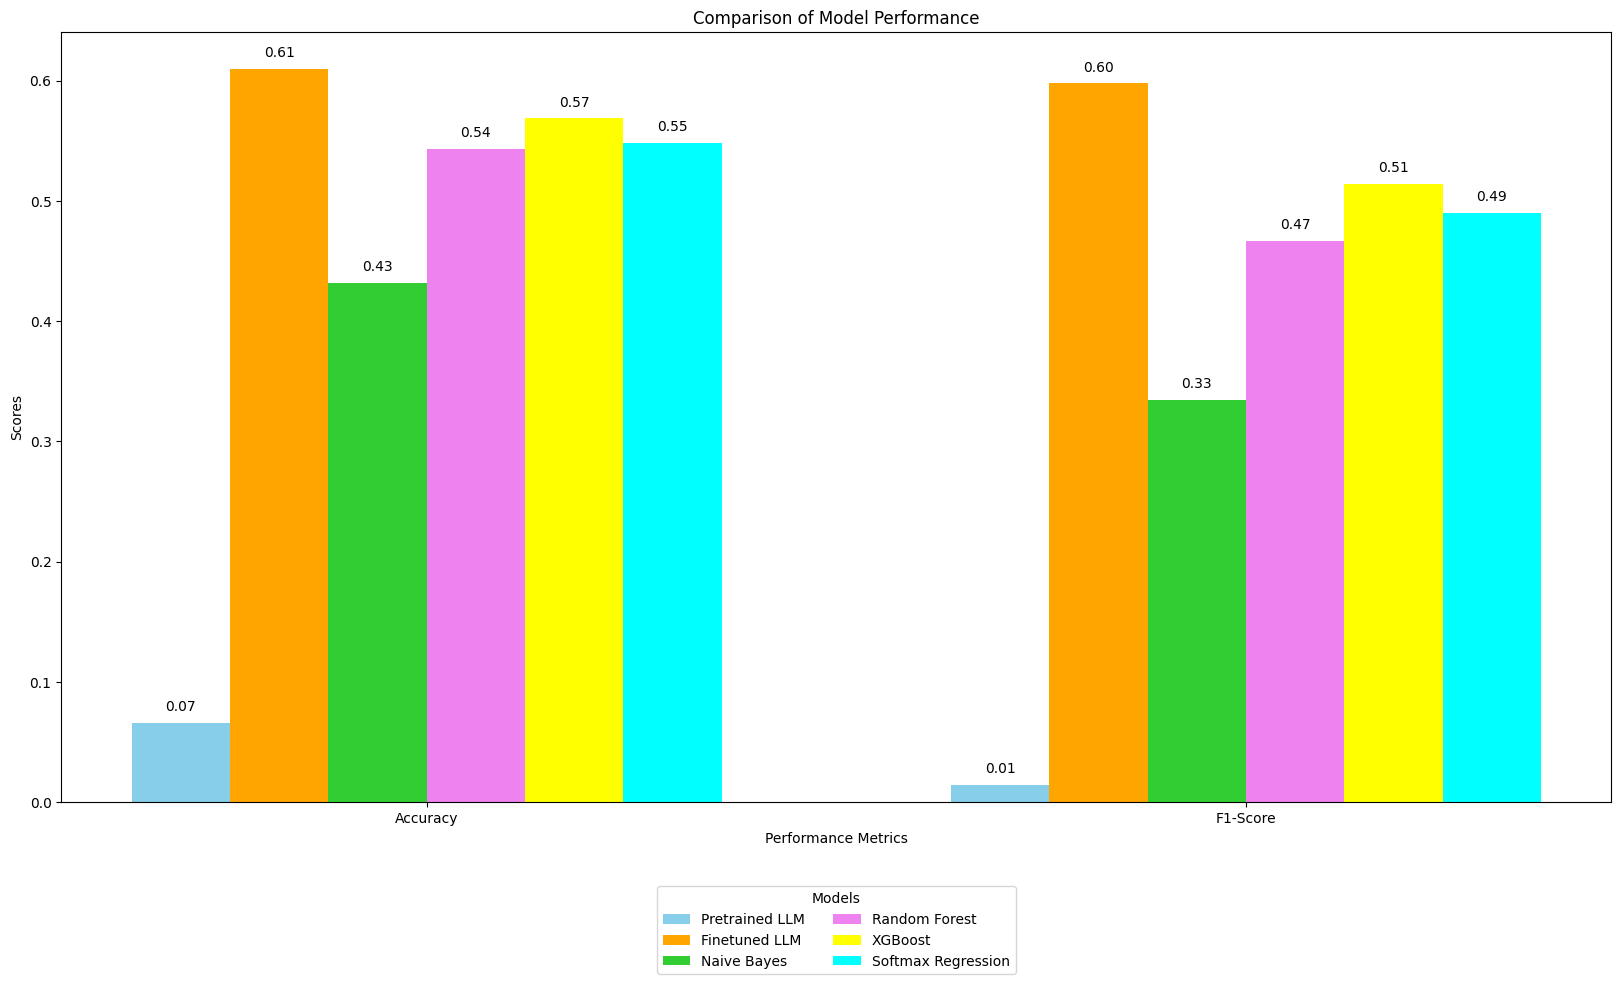

In [115]:
### PLOT THE MODELS PERFORMANCE METRICS - REPLACE TEST_ACCS and F1

# Data: REPLACE WITH ACTUAL METRICS FOR LLM AND NB
models = ['Pretrained LLM', 'Finetuned LLM', 'Naive Bayes', 'Random Forest', 'XGBoost', 'Softmax Regression']
test_accs = [0.0656, 0.6098, 0.431507, 0.543305, 0.5685, 0.5482]
test_f1s = [0.0141, 0.5976, 0.334777, 0.466811, 0.5142 , 0.4897]


# Define categories and colors
categories = ['Accuracy', 'F1-Score']
metrics = [test_accs, test_f1s]  # Group metrics by category
colors = ['skyblue', 'orange', 'limegreen', 'violet', 'yellow', 'cyan']  # Assign a color to each model


# Bar width and positions
x = np.arange(len(categories))  # X positions for categories
bar_width = 0.12           # Width of each bar
offsets = np.linspace(-bar_width * 2.5, bar_width * 2.5, len(models))  # Offsets for subcategories

# Create the plot
plt.figure(figsize=(20, 10))

# Plot bars for each model within each category
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]  # Get metric values for the model
    plt.bar(x + offsets[i], values, width=bar_width, label=model, color=colors[i])

# Add labels, title, and legend
plt.xlabel('Performance Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(x, categories)  # Set categories as x-axis labels
plt.legend(title='Models', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # move legend below


# Add value labels on top of the bars
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]
    for j, value in enumerate(values):
        plt.text(x[j] + offsets[i], value + 0.01, f'{value:.2f}', ha='center')

# Show the plot
#plt.tight_layout()
plt.show()

As seen in the performance metrics chart above, the baseline models perform very similarly on the test set to one another. Since their purpose in this project is simply to provide a baseline, the choice between the three does not have a significant impact.

####**Feature Selection with Random Forest**

In [106]:
from sklearn.feature_selection import SelectFromModel

The SelectFromModel method from sklearn.feature_selection ensures only the most important features are used within the Random Forest Classifier model. In this case, we use the feature_importances_ method from the Random Forest Classifier itself to observe the "importance" of each word when classifying emotion. The importance of the 1,000th is then used to approximate the threshold of the feature selector.

In [111]:
#get the words from the text back from tf-irf vectorizer
words = vectorizer.get_feature_names_out()

#use feature_imortances_ from randomforest
importances = rf_classifier.feature_importances_
sorted_imps = sorted(importances, reverse = True)

#get the top 50 most important features
top_1000_imps = sorted_imps[:1000]
top_1000_indices = np.argsort(importances)[::-1][:1000]


#print the top and bottom 10
for i, index in enumerate(top_1000_indices):
  if i < 10:
    print(f"Top {i+1} important word: " + words[index])
    print(f"with importance: {top_1000_imps[i]}")
  else:
    if i == 19:
      print( )
      print(f"Top 20 important word: " + words[index])
      print(f"with importance: {top_1000_imps[i]}")
    if i == 49:
      print(f"Top 50 important word: " + words[index])
      print(f"with importance: {top_1000_imps[i]}")
    if i == 99:
      print(f"Top 100 important word: " + words[index])
      print(f"with importance: {top_1000_imps[i]}")
    if i == 999:
      print(f"Top 1000 important word: " + words[index])
      print(f"with importance: {top_1000_imps[i]}")

Top 1 important word: love
with importance: 0.019767686164974405
Top 2 important word: thanks
with importance: 0.019157750342171227
Top 3 important word: thank
with importance: 0.01474471568666457
Top 4 important word: lol
with importance: 0.014672102343035665
Top 5 important word: you
with importance: 0.008657669307650292
Top 6 important word: the
with importance: 0.00838659386376391
Top 7 important word: that
with importance: 0.007492261277244328
Top 8 important word: great
with importance: 0.007301561451509376
Top 9 important word: it
with importance: 0.0071613608041999
Top 10 important word: to
with importance: 0.006820972986297823

Top 20 important word: of
with importance: 0.004749647609215683
Top 50 important word: sad
with importance: 0.0027652331934221977
Top 100 important word: him
with importance: 0.0015647377444991304
Top 1000 important word: touch
with importance: 0.00012851504964903946


In [112]:
selector = SelectFromModel(rf_classifier, threshold=0.00012)
#using approximately 1000th highest importance value as threshold

X_train_selected = selector.transform(X_train_baseline)
X_test_selected = selector.transform(X_test_baseline)


rf_classifier1 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                                       max_samples=None, monotonic_cst=None)


start_time = time.time()

rf_classifier1.fit(X_train_selected, y_train_baseline)

elapsed_time = time.time() - start_time

y_train_pred = rf_classifier1.predict(X_train_selected)
y_test_pred = rf_classifier1.predict(X_test_selected)

train_acc = accuracy_score(y_train_baseline, y_train_pred)
train_f1 = f1_score(y_train_baseline, y_train_pred, average='weighted')
test_acc = accuracy_score(y_test_baseline , y_test_pred)
test_f1 = f1_score(y_test_baseline, y_test_pred, average='weighted')

feat_sel_acc = test_acc
feat_sel_f1 = test_f1



print(f"\nRandom Forest Classifier training set accuracy with default parameters: " + str(train_acc))
print(f"\nRandom Forest Classifier training set f1 score with default parameters: " + str(train_f1))
print(f"\nRandom Forest Classifier test set accuracy with default parameters: " + str(test_acc))
print(f"\nRandom Forest Classifier test set f1 score with default parameters: " + str(test_f1))
print(f"\tTraining time: {elapsed_time}")

enhanced_classification_report(y_test_baseline, y_test_pred)



Random Forest Classifier training set accuracy with default parameters: 0.9944912055032018

Random Forest Classifier training set f1 score with default parameters: 0.9944827189557476

Random Forest Classifier test set accuracy with default parameters: 0.5536897923110915

Random Forest Classifier test set f1 score with default parameters: 0.49230960624426207
	Training time: 76.07912135124207

             class  precision  recall  f1-score    support  accuracy
0       admiration     0.6012  0.5819    0.5914   342.0000    0.5819
1        amusement     0.7268  0.7430    0.7348   179.0000    0.7430
2            anger     0.4578  0.2923    0.3568   130.0000    0.2923
3        annoyance     0.4138  0.0625    0.1086   192.0000    0.0625
4         approval     0.5167  0.1348    0.2138   230.0000    0.1348
5           caring     0.5714  0.1395    0.2243    86.0000    0.1395
6        confusion     0.6316  0.1250    0.2087    96.0000    0.1250
7        curiosity     0.3864  0.0966    0.1545   17

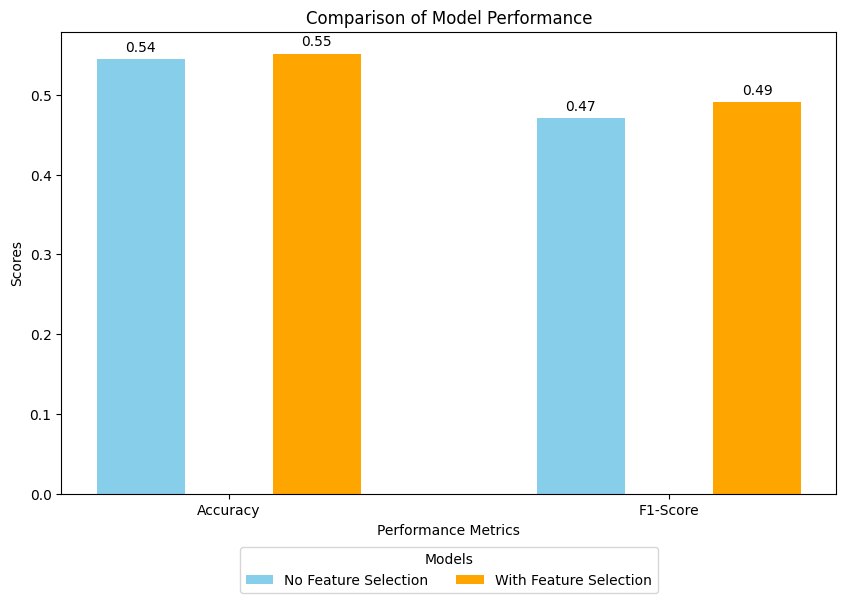

In [91]:

models = ['No Feature Selection', 'With Feature Selection']
test_accs = [rf_acc, feat_sel_acc]  # Accuracy values
test_f1s = [rf_f1, feat_sel_f1]   # F1-score values


# Define categories and colors
categories = ['Accuracy', 'F1-Score']
metrics = [test_accs, test_f1s]  # Group metrics by category
colors = ['skyblue', 'orange', 'limegreen', 'violet']  # Assign a color to each model


# Bar width and positions
x = np.arange(len(categories))  # X positions for categories
bar_width = 0.2              # Width of each bar
offsets = np.linspace(-bar_width , bar_width , len(models))  # Offsets for subcategories

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars for each model within each category
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]  # Get metric values for the model
    plt.bar(x + offsets[i], values, width=bar_width, label=model, color=colors[i])

# Add labels, title, and legend
plt.xlabel('Performance Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(x, categories)  # Set categories as x-axis labels
plt.legend(title='Models', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # move legend below


# Add value labels on top of the bars
for i, model in enumerate(models):
    values = [metrics[j][i] for j in range(len(categories))]
    for j, value in enumerate(values):
        plt.text(x[j] + offsets[i], value + 0.01, f'{value:.2f}', ha='center')

# Show the plot
#plt.tight_layout()
plt.show()

When using a threshold value of 0.00012, the model that uses feature selection is able to slightly surpass the performance of the model that doesn't. As seen above, when predicting on the test set, both the accuracy and f1 score are higher on the model that uses feature selection.

#### Accuracy Comparison - Pre-Implemented vs. Custom Naive Bayes

Background: During our experimentation with a custom Naive Bayes implementation, we noticed a \~45-50% performance on average on the train and test sets. Although we attribute this largely to the nature of the model and the inconsistency in class frequencies, making a comparison with a pre-implemented model will confirm our assumptions that the accuracy is model-related and not an issue with implementation.

- We will use sklearn's MultinomialNB model here, and compare train and test accuracy against those generated by our own Multinomial Naive Bayes model.

In [93]:
pre_implemented_model = MultinomialNB() # Initialize model

pre_implemented_model.fit(x_train_bayes_sparse, y_train_bayes) # Fit on our data

MultinomialNB()

In [94]:
# Make train and validation predictions - Pre-implemented model
pre_implemented_predictions_train = pre_implemented_model.predict(x_train_bayes)
pre_implemented_train_accuracy = MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, pre_implemented_predictions_train)

pre_implemented_predictions_test = pre_implemented_model.predict(x_test_bayes)
pre_implemented_test_accuracy = MultinomialNaiveBayes.evaluate_avg_acc(y_test_bayes, pre_implemented_predictions_test)



train_predictions = optimal_naive_bayes.predict(x_train_bayes)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_accuracy = MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels)

test_predictions = optimal_naive_bayes.predict(x_test_bayes)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_accuracy = MultinomialNaiveBayes.evaluate_avg_acc(y_test_bayes, test_predicted_labels)



In [95]:
# Accuracy breakdown - Alternate metrics (pre-implemented model) -- Metrics for our model are visible in section 3.1
print("ADVANCED METRICS - TRAIN SET (PRE-IMPLEMENTED MODEL)\n")
enhanced_classification_report(y_train_bayes, pre_implemented_predictions_train)

print("\n\nADVANCED METRICS - TEST SET (PRE-IMPLEMENTED MODEL)\n")
enhanced_classification_report(y_test_bayes, pre_implemented_predictions_test)

ADVANCED METRICS - TRAIN SET (PRE-IMPLEMENTED MODEL)


             class  precision  recall  f1-score     support  accuracy
0       admiration     0.7837  0.5498    0.6462   2663.0000    0.5498
1        amusement     0.8882  0.3393    0.4910   1615.0000    0.3393
2            anger     0.8834  0.1417    0.2443   1016.0000    0.1417
3        annoyance     0.8434  0.0973    0.1745   1439.0000    0.0973
4         approval     0.8608  0.1281    0.2231   1834.0000    0.1281
5           caring     0.7895  0.0234    0.0455    640.0000    0.0234
6        confusion     0.9667  0.0340    0.0658    852.0000    0.0340
7        curiosity     0.9118  0.0910    0.1654   1363.0000    0.0910
8           desire     0.9000  0.0240    0.0468    375.0000    0.0240
9   disappointment     0.9259  0.0356    0.0686    702.0000    0.0356
10     disapproval     0.8976  0.0822    0.1506   1387.0000    0.0822
11         disgust     0.9487  0.0747    0.1386    495.0000    0.0747
12   embarrassment     1.0000  0.01

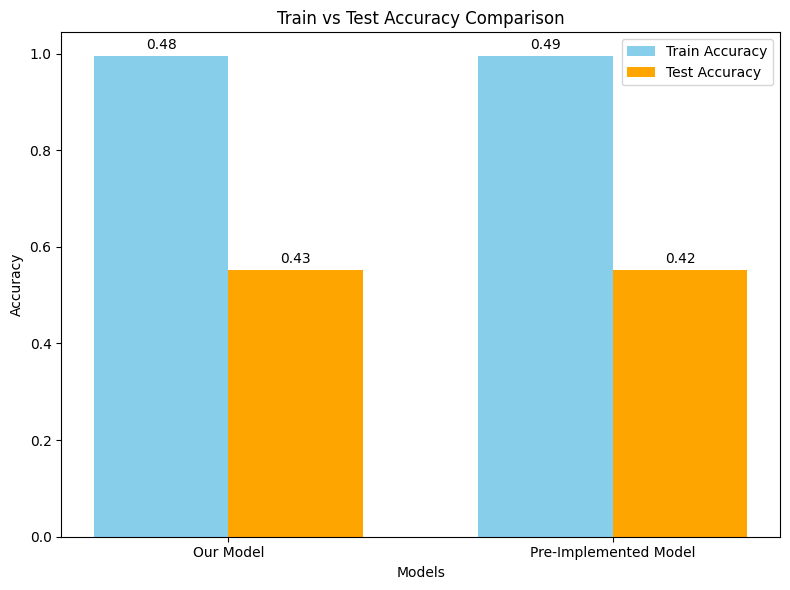

In [96]:
# Comparison - Pre-implemented model vs. Our model
models = ['Our Model', 'Pre-Implemented Model']
train_accs = [train_accuracy, pre_implemented_train_accuracy]
test_accs = [test_accuracy, pre_implemented_test_accuracy]


x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='skyblue')
bar2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Train vs Test Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
# Annotate bars with accuracy values
for bar, acc in zip(bar1, train_accs):
    height = bar.get_height()
    ax.annotate(f'{acc:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom')

for bar, acc in zip(bar2, test_accs):
    height = bar.get_height()
    ax.annotate(f'{acc:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

**Analysis**

As we can see, the models perform very similarly on both train and test data. Our model performs slightly better on the test set and slightly worse on the training set, which aligns with the fact that we implemented "regularization" through increasing the Laplace Smoothing coefficient.

- This confirms our theory that the sub-optimal performance of these models on the data is not due to our own implementation, but rather to the nature of the models themselves and the structure of the data we were provided with.

#### Naive Bayes - Vocabulary Size vs. Laplace Smoothing Coefficient as Regularization

In the hyperparameter tuning section of our Multinomial Naive Bayes model implementation, we saw how increasing the Laplace Smoothing coefficient could act as a form of "regularization", increasing bias and consequently the performance on the test set.

- By testing our model on smaller vocabularies (e.g. by removing the least frequently used words), we can see whether our model benefits from training/prediction speed and overfitting reduction.



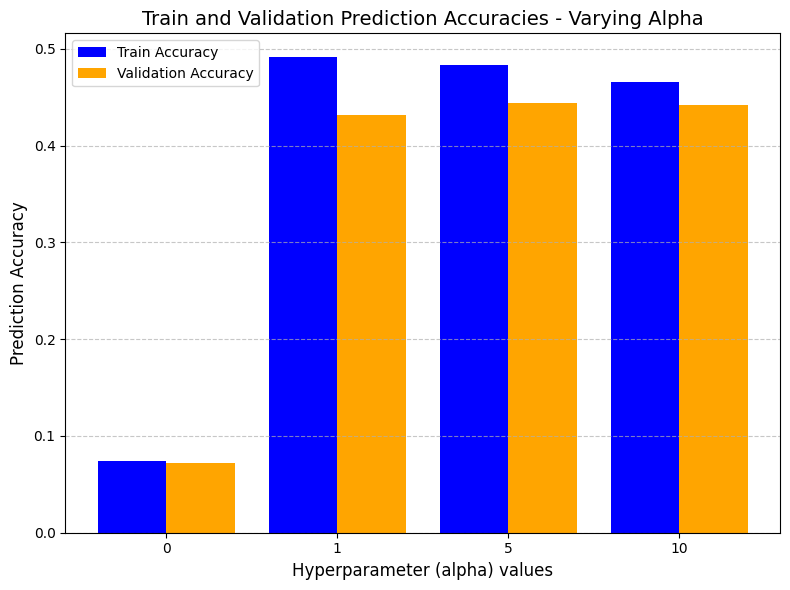

In [97]:
# As a background, here is our plot of alpha (Laplace Smoothing Coefficient) and its effect on generalization. (taken from Task 2A)

alphas = ["0", "1", "5", "10"]  # Labels for bar groups

# Parameters for the bar chart
x = np.arange(len(alphas))  # x positions for groups
bar_width = 0.4  # Width of each bar
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars
ax.bar(x - bar_width/2, train_pred_accuracies, width=bar_width, label='Train Accuracy', color='blue')
ax.bar(x + bar_width/2, validation_pred_accuracies, width=bar_width, label='Validation Accuracy', color='orange')

# Customize the chart
ax.set_xlabel('Hyperparameter (alpha) values', fontsize=12)
ax.set_ylabel('Prediction Accuracy', fontsize=12)
ax.set_title('Train and Validation Prediction Accuracies - Varying Alpha', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(alphas)
ax.legend()

# Show grid and plot
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [98]:
# To use a smaller vocabulary, we will use our CountVectorizer() object to only train our model with high-enough frequency words.

# Will compute train and test predictions using our new models
# Note: We are predicting on the modified train dataset!

# First, add results from model without vocabulary shrinking
train_accuracies_bayes_test = []
validation_accuracies_bayes_test = []

train_accuracies_bayes_test.append(
    MultinomialNaiveBayes.evaluate_avg_acc(y_train_bayes, train_predicted_labels_1) # Model from hyperparam tuning section
)

validation_accuracies_bayes_test.append(
     MultinomialNaiveBayes.evaluate_avg_acc(y_validation_bayes, validation_predicted_labels_1) # Model from hyperparam tuning section
)


# We will use this data to train a variety of Naive Bayes models (using a low alpha = 1 value) and observing the effects on bias/variance.

bayes_vectorizer_low_elimination = CountVectorizer(min_df=2) # First, initialize vectorizers dropping various amounts of words
bayes_vectorizer_med_elimination = CountVectorizer(min_df=5)
bayes_vectorizer_high_elimination = CountVectorizer(min_df=10)

print(train_accuracies_bayes_test)

[0.49145717401638656]


In [99]:
from sklearn.metrics import accuracy_score

vocab_train_predictions = []
vocab_validation_predictions = []

x_train_bayes_sparse_low = bayes_vectorizer_low_elimination.fit_transform(clean_train_df['text'])
x_train_bayes_sparse_med = bayes_vectorizer_med_elimination.fit_transform(clean_train_df['text'])
x_train_bayes_sparse_high = bayes_vectorizer_high_elimination.fit_transform(clean_train_df['text'])


# Transform validation data using the same vectorizers
x_validation_bayes_sparse_low = bayes_vectorizer_low_elimination.transform(clean_validation_df['text'])
x_validation_bayes_sparse_med = bayes_vectorizer_med_elimination.transform(clean_validation_df['text'])
x_validation_bayes_sparse_high = bayes_vectorizer_high_elimination.transform(clean_validation_df['text'])

mnb_low = MultinomialNB()
mnb_med = MultinomialNB()
mnb_high = MultinomialNB()

# Add the fourth model and its respective vectorized data
results = []

for model, x_train, x_val, name in zip(
    [mnb_low, mnb_med, mnb_high, mnb_high],
    [x_train_bayes_sparse_low, x_train_bayes_sparse_med, x_train_bayes_sparse_high, x_train_bayes_sparse_high],
    [x_validation_bayes_sparse_low, x_validation_bayes_sparse_med, x_validation_bayes_sparse_high, x_validation_bayes_sparse_high],
    ['low', 'medium', 'high']
):
    # Train the model
    model.fit(x_train, clean_train_df['labels'])

    # Predict on train and validation sets
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    vocab_train_predictions.append(y_train_pred)
    vocab_validation_predictions.append(y_val_pred)

    # Compute accuracy
    train_acc = accuracy_score(clean_train_df['labels'], y_train_pred)
    val_acc = accuracy_score(clean_validation_df['labels'], y_val_pred)
    train_accuracies_bayes_test.append(train_acc)
    validation_accuracies_bayes_test.append(val_acc)

    # Store the results
    results.append({'vocab_size': name, 'train_acc': train_acc, 'val_acc': val_acc})

# Display results
for result in results:
    print(f"Vocabulary size ({result['vocab_size']}): Train Accuracy = {result['train_acc']:.4f}, Validation Accuracy = {result['val_acc']:.4f}")

Vocabulary size (low): Train Accuracy = 0.5616, Validation Accuracy = 0.4647
Vocabulary size (medium): Train Accuracy = 0.6111, Validation Accuracy = 0.4984
Vocabulary size (high): Train Accuracy = 0.6171, Validation Accuracy = 0.5208


Train accuracies: [0.49145717401638656, 0.5615614775873158, 0.6110847012108163, 0.6171248007606052]
Validation accuracies: [0.43125, 0.46473214285714287, 0.4984375, 0.5207589285714286]


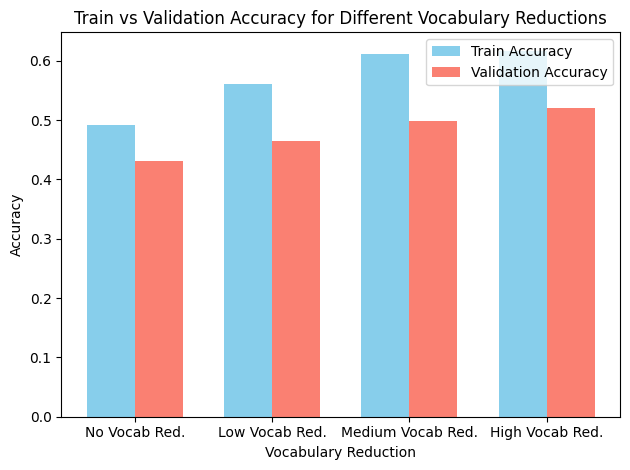

In [100]:
print("Train accuracies:", train_accuracies_bayes_test)
print("Validation accuracies:", validation_accuracies_bayes_test)

# Define the labels for the models
labels = ['No Vocab Red.', 'Low Vocab Red.', 'Medium Vocab Red.', 'High Vocab Red.']

# Set the x positions for the bars
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35  # the width of the bars

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the bars for train and validation accuracies
bar1 = ax.bar(x - width/2, train_accuracies_bayes_test, width, label='Train Accuracy', color='skyblue')
bar2 = ax.bar(x + width/2, validation_accuracies_bayes_test, width, label='Validation Accuracy', color='salmon')

# Add some labels and title
ax.set_xlabel('Vocabulary Reduction')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Validation Accuracy for Different Vocabulary Reductions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



In [101]:
# E.g. detailed analysis for high-reduction model
print("ADVANCED METRICS - TRAIN SET (HIGH REDUCTION MODEL)\n")
enhanced_classification_report(y_train_bayes, vocab_train_predictions[-1])

print("\n\nADVANCED METRICS - TEST SET (HIGH REDUCTION MODEL)\n")
enhanced_classification_report(y_validation_bayes, vocab_validation_predictions[-1])

ADVANCED METRICS - TRAIN SET (HIGH REDUCTION MODEL)


             class  precision  recall  f1-score     support  accuracy
0       admiration     0.6597  0.7184    0.6878   2663.0000    0.7184
1        amusement     0.7736  0.7616    0.7676   1615.0000    0.7616
2            anger     0.6767  0.4409    0.5340   1016.0000    0.4409
3        annoyance     0.5680  0.2613    0.3579   1439.0000    0.2613
4         approval     0.5811  0.2890    0.3860   1834.0000    0.2890
5           caring     0.5336  0.3844    0.4469    640.0000    0.3844
6        confusion     0.6634  0.3169    0.4289    852.0000    0.3169
7        curiosity     0.5740  0.3015    0.3954   1363.0000    0.3015
8           desire     0.8312  0.3413    0.4839    375.0000    0.3413
9   disappointment     0.7170  0.2165    0.3326    702.0000    0.2165
10     disapproval     0.5400  0.2675    0.3578   1387.0000    0.2675
11         disgust     0.7621  0.3495    0.4792    495.0000    0.3495
12   embarrassment     0.8718  0.169

**Analysis**

As we can see, vocabulary reduction works very well both as a method of "regularization" and as a method of increasing model accuracy overall! We observe better performance on the train and validation sets by increasing our vocabulary reduction.

This works for several reasons:
- Noise reduction: We are able to filter out irrelevant, uncommon words that do not make many contributions to the predictions. This can also include potential typos.
- Generalization: Since we prevent the model from overfitting to noise or overly specific features, we see better performance even in less common classes.